# Intrusion detection system in Machine Learning
## Introduction
This work presents three machine learning-based classification algorithms to automatically detect different attacks within a private network. This work has two objectives :
    1) Learn more about machine learning and datascience.
    2) See if a system trained on only one type of attack (for example DOS) is able to detect other types of attack (BruteForce, Port scan, DDOS, etc.) within an office private network.

## Dataset description and visualisation
The dataset used for this project is ‘CICIDS-2017’, developed by the Canadian institute for cyber-security of the university of New Brunswick. It represents the network traffic of a fictional office during a period of one week.
Each day of the week contains one or two types of attack (except for monday, which contains only legitimate traffic). The entire dataset is separated in 8 files. 

  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from pathlib import Path

Note : We will only work with the sub-datasets which contains attacks and normal actions. So we will not use the monday subset.

In [3]:
path = r"dataset/archive/MachineLearningCSV/MachineLearningCVE/"

df_DOS = pd.read_csv(Path(path+"Wednesday-workingHours.pcap_ISCX.csv"))
df_BruteForce = pd.read_csv(Path(path+"Tuesday-WorkingHours.pcap_ISCX.csv"))
df_WebAttack = pd.read_csv(Path(path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"))
df_infiltration = pd.read_csv(Path(path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"))
df_bot = pd.read_csv(Path(path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"))
df_DDOS = pd.read_csv(Path(path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"))
df_PortScan = pd.read_csv(Path(path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"))


In [3]:
list_df = [df_DOS, df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan]

In [4]:
df_viz = pd.concat(list_df, axis=0, ignore_index=True)

Size of the entire dataset and a quick view of how it looks like.

In [6]:
print('Total size of the dataset :', df_viz.shape)
df_viz.head(n=15)

Total size of the dataset : (2300825, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,389,433,11,4,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,88,1088,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,80,579225,132,150,160,320799,160,0,1.212121,13.926212,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,49666,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,49413,4,3,0,18,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


What are the different value types in our dataset ?!

In [6]:
def value_type_viz(dataframe):
    col_names = dataframe.columns
    col_types = dataframe.dtypes
    indexI = 0
    compteurI = 1
    for col_name in col_names:
        print(str(compteurI)+" : ", col_name, ":", col_types[indexI], end='\n')
        indexI += 1
        compteurI += 1

print(value_type_viz(df_viz))

1 :   Destination Port : int64
2 :   Flow Duration : int64
3 :   Total Fwd Packets : int64
4 :   Total Backward Packets : int64
5 :  Total Length of Fwd Packets : int64
6 :   Total Length of Bwd Packets : int64
7 :   Fwd Packet Length Max : int64
8 :   Fwd Packet Length Min : int64
9 :   Fwd Packet Length Mean : float64
10 :   Fwd Packet Length Std : float64
11 :  Bwd Packet Length Max : int64
12 :   Bwd Packet Length Min : int64
13 :   Bwd Packet Length Mean : float64
14 :   Bwd Packet Length Std : float64
15 :  Flow Bytes/s : float64
16 :   Flow Packets/s : float64
17 :   Flow IAT Mean : float64
18 :   Flow IAT Std : float64
19 :   Flow IAT Max : int64
20 :   Flow IAT Min : int64
21 :  Fwd IAT Total : int64
22 :   Fwd IAT Mean : float64
23 :   Fwd IAT Std : float64
24 :   Fwd IAT Max : int64
25 :   Fwd IAT Min : int64
26 :  Bwd IAT Total : int64
27 :   Bwd IAT Mean : float64
28 :   Bwd IAT Std : float64
29 :   Bwd IAT Max : int64
30 :   Bwd IAT Min : int64
31 :  Fwd PSH Flags : int64

C:\Users\Comar\AppData\Local\Temp\ipykernel_22800\326535405.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(compteurI)+" : ", col_name, ":", col_types[indexI], end='\n')


A few column titles start with a space (' '). This space will be removed.

How many different labels do we have ?!

In [8]:
lab_count = df_viz[' Label'].value_counts()
print(lab_count)

# We check the integrity of the datasets by adding all the record together.
c=0
for count in lab_count:
    c+=count
print("\naddition of all recordings :", c)

 Label
BENIGN                        1743179
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

addition of all recordings : 2300825


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


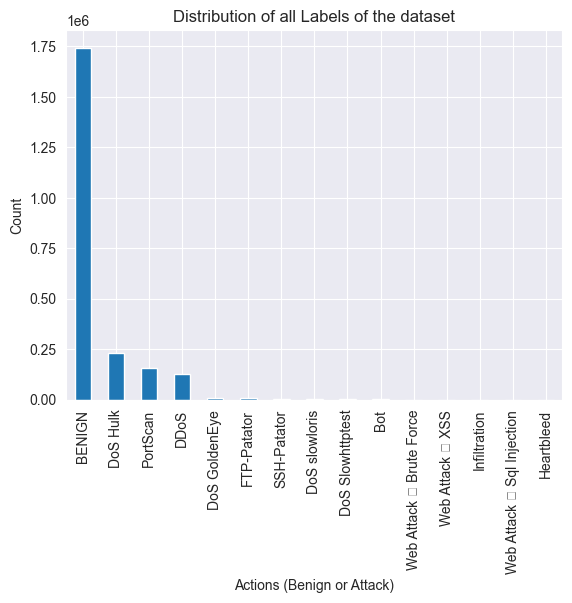

In [58]:
lab_count.plot(kind='bar')
plt.title('Distribution of all Labels of the dataset')
plt.xlabel('Actions (Benign or Attack)')
plt.ylabel('Count')
plt.show()

The 'BENIGN' actions are over-represented.
Some attacks have very few recordings.
'PortScan', 'DOS' and 'DDOS' have a decent representation. FTP and SSH 'Patator' also, but a bit less.

Some attacks can be grouped together. More precisely, those that are found in the same sub-dataset. This will give a better overview of the proportion of attacks.

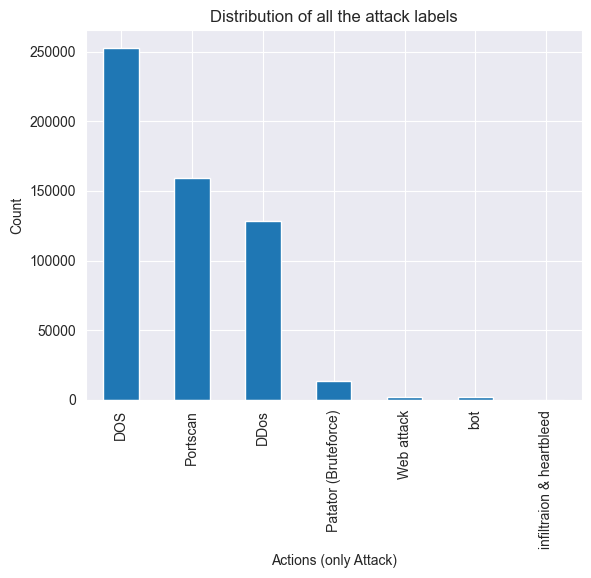

DOS                         252661
Portscan                    158930
DDos                        128027
Patator (Bruteforce)         13835
Web attack                    2180
bot                           1966
infiltraion & heartbleed        47
dtype: int64

In [60]:
DOS_count = lab_count.loc[['DoS GoldenEye', 'DoS Hulk', 'DoS slowloris', 'DoS Slowhttptest']].sum()
Patator_count = lab_count.loc[['FTP-Patator', 'SSH-Patator']].sum()
web_att_count = lab_count.iloc[[10,11,13]].sum()
DDos_count = lab_count.iloc[3].sum()
Portscan_count = lab_count.iloc[2].sum()
bot_count= lab_count.iloc[9].sum()
other_count = lab_count.iloc[[12,14]].sum()
nameforcount = ['DOS', 'Portscan', 'DDos', 'Patator (Bruteforce)', 'Web attack', 'bot',  'infiltraion & heartbleed']
count_serie = pd.Series([DOS_count, Portscan_count, DDos_count, Patator_count, web_att_count, bot_count, other_count])
count_serie.index = nameforcount
count_serie.plot(kind='bar')
plt.title('Distribution of all the attack labels')
plt.xlabel('Actions (only Attack)')
plt.ylabel('Count')
plt.show()
count_serie

For the training set, we will only use sub-sets with a decent representation of attacks. 
Using DOS ands DDOS is a bit boring because both attacks are very similar.
We will train the models with DOS, PortScan and BruteForce sub-sets !



Does the dataset contains 'NaN' values ?

In [15]:
empty_cols = df_viz.dropna(axis=0, how='any')
print("Initial Lenght :", len(df_viz), "\nNumber of lines with 'NaN' value :", len(df_viz) - len(empty_cols))

Initial Lenght : 2300825 
Number of lines with 'NaN' value : 1294


In [9]:
rows_with_na = df_viz[df_viz.isna().any(axis='columns')]
rows_with_na

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5106,80,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5833,49578,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8381,59597,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8552,41699,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
14762,43832,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252374,48894,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2253944,49066,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2267572,37398,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2273434,49858,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



There are two columns with undesired values. Those are 'Flow Bytes/s' and 'Flow Packets/s'. This result can be explained by the fact that, for all those rows, the flow duration was null. That can explain why the bytes and packets flows have special values.
 

In [10]:
rows_with_na[[' Flow Duration', 'Flow Bytes/s', ' Flow Packets/s']]

,Flow Duration,Flow Bytes/s,Flow Packets/s
5106,0,NaN,inf
5833,0,NaN,inf
8381,0,NaN,inf
8552,0,NaN,inf
14762,0,NaN,inf
...,...,...,...
2252374,0,NaN,inf
2253944,0,NaN,inf
2267572,0,NaN,inf
2273434,0,NaN,inf


It is certain that the dataset contains forbidden values. But which sub-datasets contains them ?

In [24]:
def which_one(listofdataframes):
    res_l = []
    for df in listofdataframes:
        if df.isna().any().any():
            res_l.append(True)
        else:
            res_l.append(False)
    return res_l

name_df = ['df_DOS', 'df_BruteForce', 'df_WebAttack', 'df_infiltration', 'df_bot', 'df_DDOS', 'df_PortScan']
j=0
for i in which_one(list_df):
    print(name_df[j], ':', i, end='\n')
    j+=1

df_DOS : True
df_BruteForce : True
df_WebAttack : True
df_infiltration : True
df_bot : True
df_DDOS : True
df_PortScan : True


Every subset of the dataset contains 'NaN' and 'inf' values. Those will have to be removed !


Now we need to determine the correlations between the features for each training sub-set. As there are 79 columns, a heatmap would be unreadable. Instead, the list of the 10 highest correlations will be displayed.

In [9]:
def features_correlation(df):
    df_viz_features = df.drop(' Label', axis=1)
    corr_matrix = df_viz_features.corr()
    corr_pairs = corr_matrix.unstack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
    corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])
    top_corr_pairs = corr_pairs.reindex(corr_pairs.Correlation.abs().sort_values(ascending=False).index).head(10)
    return top_corr_pairs

In [11]:
print('df_DOS correlation :\n', features_correlation(df_DOS), end='\n')
print('\n\ndf_PortScan correlation :\n', features_correlation(df_PortScan), end='\n')
print('\n\ndf_BruteForce correlation :\n', features_correlation(df_BruteForce), end='\n')

df_DOS correlation :
                           Feature1               Feature2  Correlation
990         Bwd Packet Length Mean   Avg Bwd Segment Size     1.000000
218              Total Fwd Packets    Subflow Fwd Packets     1.000000
455    Total Length of Bwd Packets      Subflow Bwd Bytes     1.000000
2794             Bwd Header Length    Subflow Bwd Packets     0.999933
269         Total Backward Packets      Bwd Header Length     0.999933
190              Total Fwd Packets      Fwd Header Length     0.999768
224              Total Fwd Packets       act_data_pkt_fwd     0.999660
1427                  Flow IAT Max            Fwd IAT Max     0.999466
98                   Flow Duration          Fwd IAT Total     0.999268
2687             Fwd Header Length      Bwd Header Length     0.999097


df_PortScan correlation :
                  Feature1              Feature2  Correlation
218     Total Fwd Packets   Subflow Fwd Packets     1.000000
98          Flow Duration         Fwd IAT Tota

## Preprocessing
here are our preprocessing objectives :
- A few column's titles start with a space, This space has to be removed !
- Deleting the NaN values (there are only 1300 Benign actions with 'NaN' and 'inf' values, out of 2'000'000)
- Changing the port number values between : 'Dedicated' (0-1023) = 0 ; 'dynamic' (1024-65'536) = 1
        - The port number can take a value between 1 and 65'536. A high port number can have a significant impact on the prediction of certain models, such as KNN. In this kind of situation, it would be wiser to binarize the port number between dedicated and dynamic port numbers.
- Creating a new binary column for the labels :
        - Binary Label --> Attack = 1 ; Benign = 0
- A method for taking the absolute value of negative values 
- Scikit-learn's 'train_test_split()' method takes a dataframe as parameter and separates it into training and test sub-datasets. We need the same method, but with 2 datasets as arguments, as our different attacks are already separated into sub-sets. One dataset becomes the training set and the other the test set. 

In [3]:
def dataframe_preprocessing(dataframe): # this method call most of the methods below.
    bye_bye_negative(dataframe)         # Use on the initial datasets to make all the preprocessing steps.
    _new_col_title(dataframe)          
    _NaN_del(dataframe)
    dataframe['Bin Label'] = dataframe['Label'].apply(lambda x: _bin_labels(x))
    dataframe['Destination Port'] = dataframe['Destination Port'].apply(lambda x: port_numb_intervall(x))
    return dataframe

def bye_bye_negative(dataframe):        # take the absolute value of eventual negativ values
    dataframe.iloc[:, :-1] = dataframe.iloc[:, :-1].abs()
    return dataframe
 
def _new_col_title(dataframe):          # Delete the space in first position of certain column's title
    new_titles = []
    for mot in dataframe.columns.values: 
        if mot.startswith(' '):
            mot = mot[1:]               
            new_titles.append(mot)
        else:                           
            new_titles.append(mot)
    new_title = np.array(new_titles)
    dataframe.columns = new_title       
    return dataframe

def _NaN_del(dataframe):        # Delete 'NaN' and 'inf' values
    dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)  # replace the 'inf' values by 'NaN'
    dataframe.dropna(how='any', inplace=True)  # delete the 'NaN' values from the input dataframe
    return dataframe

def _bin_labels(label):     # Binarize the labels
    if label == 'BENIGN':
        return 0
    else:
        return 1

def port_numb_intervall(port_numb):     # Binarize the port destination
    if 0 <= port_numb <= 1023:
        return 0
    else:
        return 1

def my_train_test_split(X, Y): # takes two dataframes in argument, one become the training set, the other the test set
    ytrain = X['Bin Label']
    xtrain = X.drop(columns=['Bin Label', 'Label'])
    ytest= Y['Bin Label']
    xtest = Y.drop(columns=['Bin Label', 'Label'])
    return xtrain, xtest, ytrain, ytest

def not_a_matter_of_size(subdf, t_size):     # Shorten dataset size while maintaining the same class proportions
    good_percent = t_size/subdf.shape[0]
    shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))
    return shorted_df

def standard_data_scaler(dataframe):        # Standardise the values of the dataframe
    non_std_columns = ['Destination Port', 'Label', 'Bin Label']  # <-- We don't want to standardise those columns
    non_std_df = dataframe[non_std_columns]
    std_df = dataframe.drop(columns=non_std_columns)
    STD = StandardScaler()
    normal_data = STD.fit_transform(std_df)
    std_df = pd.DataFrame(data=normal_data, columns=std_df.columns.tolist())
    return pd.concat([std_df, non_std_df], axis=1)

def normal_data_scaler(dataframe):      # Normalise the values of the dataframe, instead of the 3 columns below
    non_normal_columns = ['Destination Port', 'Label', 'Bin Label']
    non_normal_df = dataframe[non_normal_columns]
    normal_df = dataframe.drop(columns=non_normal_columns)
    MINMAX = MinMaxScaler()
    normal_data = MINMAX.fit_transform(normal_df)
    normal_df = pd.DataFrame(data=normal_data, columns=normal_df.columns.tolist())
    return pd.concat([normal_df, non_normal_df], axis=1)

## Learning Curves and optimal parameters for each models

Goals : reduce the size of training datasets and find optimal hyperparameters for each model.

Note : a summary of the results is presented in a dataframe at the end of this chapter.

### KNN

In [3]:
df_DOS.shape

(692703, 79)

In [13]:
dataframe_preprocessing(df_DOS)
ytrain = df_DOS['Bin Label']
xtrain = df_DOS.drop(columns=['Bin Label', 'Label'])

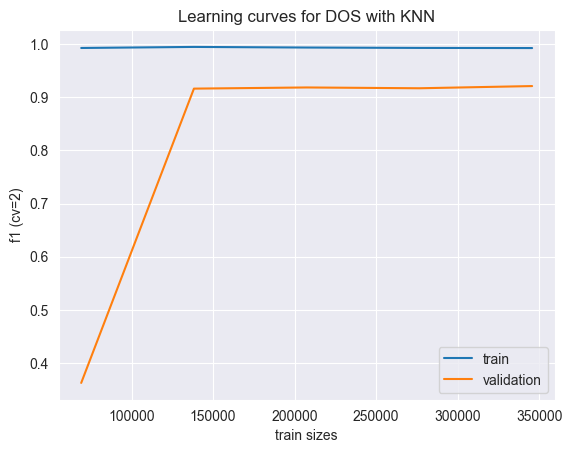

In [7]:
knn_for_DOS = KNeighborsClassifier(n_neighbors=10, p=1)
N, train_score, val_score = learning_curve(knn_for_DOS, xtrain, ytrain, train_sizes=np.linspace(0.2, 1.0, 5), cv=2, scoring='f1', n_jobs=-1)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.title('Learning curves for DOS with KNN')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=2)')
plt.legend()

In [4]:
df_PortScan.shape

(286467, 79)

In [7]:
dataframe_preprocessing(df_PortScan)
ytrain_PortScan = df_PortScan['Bin Label']
xtrain_PortScan = df_PortScan.drop(columns=['Bin Label', 'Label'])

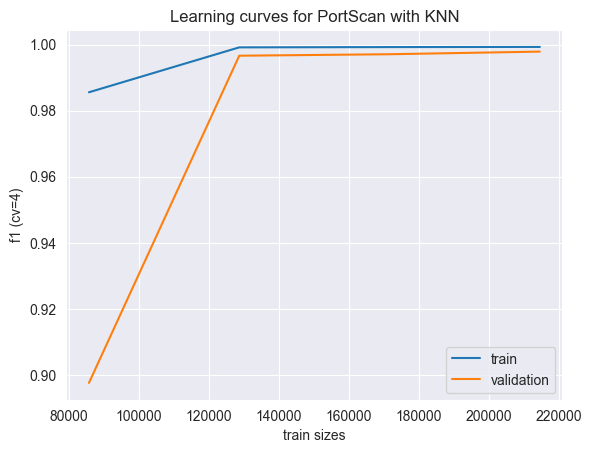

In [8]:
knn_for_PortScan = KNeighborsClassifier(n_neighbors=10, p=1)
N, train_score, val_score = learning_curve(knn_for_PortScan, xtrain_PortScan, ytrain_PortScan, train_sizes=np.linspace(0.20, 1.0, 5), scoring='f1', cv=4, n_jobs=6)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.title('Learning curves for PortScan with KNN')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=4)')
plt.legend()

In [13]:
df_BruteForce.shape

(445909, 79)

In [9]:
dataframe_preprocessing(df_BruteForce)
ytrain_Patator = df_BruteForce['Bin Label']
xtrain_Patator = df_BruteForce.drop(columns=['Bin Label', 'Label'])

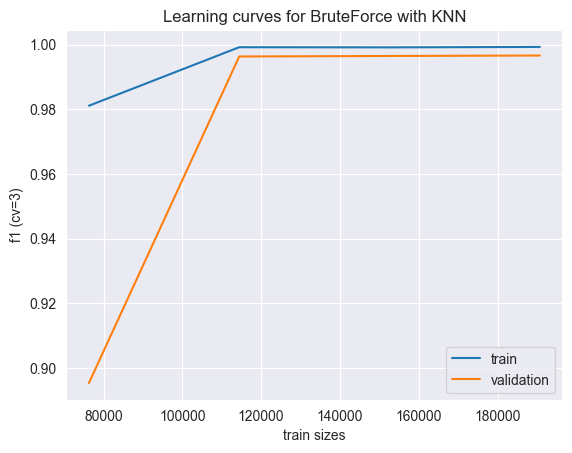

In [10]:
knn_for_Patator = KNeighborsClassifier(n_neighbors=10, p=1)
N_patator, train_score_patator, val_score_patator = learning_curve(knn_for_Patator, xtrain_Patator, ytrain_Patator, train_sizes=np.linspace(0.20, 1.0, 5), scoring='f1', cv=3, n_jobs=6)
plt.plot(N_patator, train_score_patator.mean(axis=1), label='train')
plt.plot(N_patator, val_score_patator.mean(axis=1), label='validation')
plt.title('Learning curves for BruteForce with KNN')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=3)')
plt.legend()

In [8]:
knn_params = {
    'n_neighbors':[10,15,20,30],
    'weights':['uniform', 'distance'],
    'p':[1,2]
}
knn = KNeighborsClassifier()

In [7]:
dataframe_preprocessing(df_DOS)
df_mini_DOS = not_a_matter_of_size(df_DOS, 150000)

C:\Users\Comar\AppData\Local\Temp\ipykernel_4264\1481666866.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [10]:
grid_search_knn_DOS = GridSearchCV(knn, knn_params, cv=3, scoring='f1', n_jobs=6)

In [11]:
ytrain_mini_DOS = df_mini_DOS['Bin Label']
xtrain_mini_DOS = df_mini_DOS.drop(columns=['Bin Label', 'Label'])

In [12]:
grid_search_knn_DOS.fit(xtrain_mini_DOS, ytrain_mini_DOS) # 53min

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 30], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [13]:
grid_search_knn_DOS.best_params_

{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

In [14]:
grid_search_knn_DOS.best_score_

0.9473001896217523

In [15]:
df_grid_search_knn_DOS = pd.DataFrame(grid_search_knn_DOS.cv_results_)

In [9]:
dataframe_preprocessing(df_PortScan)
df_mini_PortScan = not_a_matter_of_size(df_PortScan, 130000)

C:\Users\Comar\AppData\Local\Temp\ipykernel_14092\1006284126.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [10]:
ytrain_mini_Portscan = df_mini_PortScan['Bin Label']
xtrain_mini_PortScan = df_mini_PortScan.drop(columns=['Bin Label', 'Label'])

In [13]:
grid_search_knn_PortScan = GridSearchCV(knn, knn_params, cv=3, scoring='f1', n_jobs=6)
grid_search_knn_PortScan.fit(xtrain_mini_PortScan, ytrain_mini_Portscan)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 30], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [14]:
grid_search_knn_PortScan.best_params_

{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

In [15]:
grid_search_knn_PortScan.best_score_

0.9989818987436311

In [7]:
dataframe_preprocessing(df_BruteForce)
df_mini_BruteForce = not_a_matter_of_size(df_BruteForce, 120000)

C:\Users\Comar\AppData\Local\Temp\ipykernel_11292\1006284126.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [8]:
ytrain_mini_BruteForce = df_mini_BruteForce['Bin Label']
xtrain_mini_BruteForce = df_mini_BruteForce.drop(columns=['Bin Label', 'Label'])

In [12]:
grid_search_knn_BruteForce = GridSearchCV(knn, knn_params, cv=3, scoring='f1', n_jobs=6)
grid_search_knn_BruteForce.fit(xtrain_mini_BruteForce, ytrain_mini_BruteForce)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 30], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [13]:
grid_search_knn_BruteForce.best_params_

{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

In [14]:
grid_search_knn_BruteForce.best_score_

0.9562572650628244

### RandomForest

In [15]:
dataframe_preprocessing(df_DOS)
ytrain = df_DOS['Bin Label']
xtrain = df_DOS.drop(columns=['Bin Label', 'Label'])

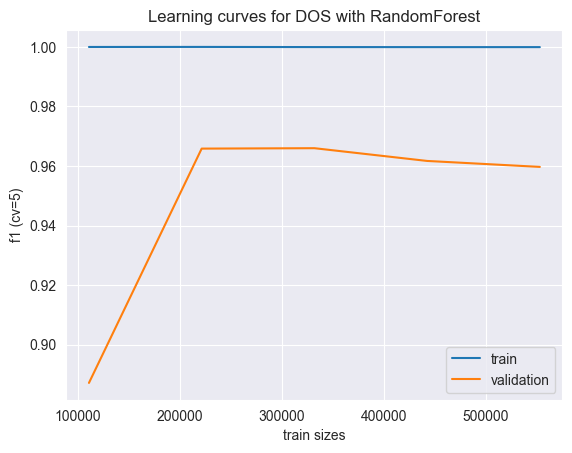

In [11]:
rf_for_DOS = RandomForestClassifier()
N, train_score, val_score = learning_curve(rf_for_DOS, xtrain, ytrain, scoring='f1', train_sizes=np.linspace(0.2, 1.0, 5), cv=5, n_jobs=6)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.title('Learning curves for DOS with RandomForest')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=5)')
plt.legend()

In [13]:
dataframe_preprocessing(df_PortScan)
ytrain_PortScan = df_PortScan['Bin Label']
xtrain_PortScan = df_PortScan.drop(columns=['Bin Label', 'Label'])

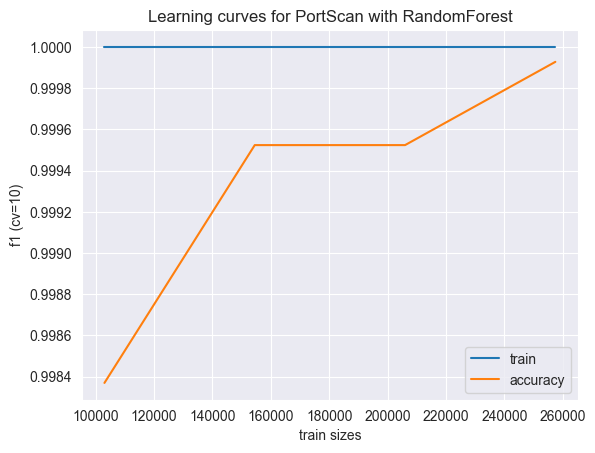

In [14]:
rf_for_PortScan = RandomForestClassifier()
N, train_score, val_score = learning_curve(rf_for_PortScan, xtrain_PortScan, ytrain_PortScan, scoring='f1', train_sizes=np.linspace(0.20, 1.0, 5), cv=10, n_jobs=6)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.title('Learning curves for PortScan with RandomForest')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=10)')
plt.legend()

In [15]:
dataframe_preprocessing(df_BruteForce)
ytrain_BruteForce = df_BruteForce['Bin Label']
xtrain_BruteForce = df_BruteForce.drop(columns=['Bin Label', 'Label'])

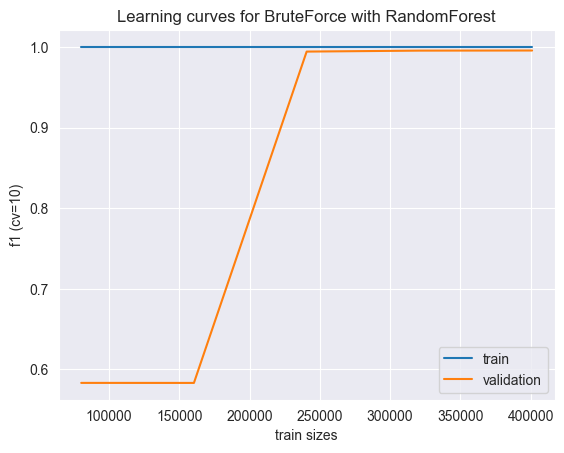

In [16]:
rf_for_BruteForce = RandomForestClassifier()
N, train_score, val_score = learning_curve(rf_for_BruteForce, xtrain_BruteForce, ytrain_BruteForce, scoring='f1', train_sizes=np.linspace(0.20, 1.0, 5), cv=10, n_jobs=6)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=10)')
plt.title('Learning curves for BruteForce with RandomForest')
plt.legend()

In [4]:
dataframe_preprocessing(df_DOS)
df_mini_DOS = not_a_matter_of_size(df_DOS, 250000)

C:\Users\Comar\AppData\Local\Temp\ipykernel_7912\1481666866.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [20]:
ytrain_mini_DOS = df_mini_DOS['Bin Label']
xtrain_mini_DOS = df_mini_DOS.drop(columns=['Bin Label', 'Label'])

In [8]:
rf_to_optimize = RandomForestClassifier()
rf_params = {
    'n_estimators':[50,100,200],
    'criterion':['gini', 'entropy'],
    'max_depth':[None,10,20],
    'max_features':['sqrt',None],
}

In [24]:
grid_search_rf_DOS = GridSearchCV(rf_to_optimize, rf_params, cv=3, scoring='f1', n_jobs=6)
grid_search_rf_DOS.fit(xtrain_mini_DOS, ytrain_mini_DOS)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [25]:
grid_search_rf_DOS.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'n_estimators': 100}

In [26]:
grid_search_rf_DOS.best_score_

0.9696375058283843

In [20]:
dataframe_preprocessing(df_PortScan)
ytrain_PortScan = df_PortScan['Bin Label']
xtrain_PortScan = df_PortScan.drop(columns=['Bin Label', 'Label'])

In [21]:
grid_search_rf_PortScan = GridSearchCV(rf_to_optimize, rf_params, cv=3, scoring='f1', n_jobs=6)
grid_search_rf_PortScan.fit(xtrain_PortScan, ytrain_PortScan)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [22]:
grid_search_rf_PortScan.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [23]:
grid_search_rf_PortScan.best_score_

0.9997542918868941

In [10]:
dataframe_preprocessing(df_BruteForce)
df_mini_BruteForce = not_a_matter_of_size(df_BruteForce, 240000)
ytrain_mini_BruteForce_GS = df_mini_BruteForce['Bin Label']
xtrain_mini_BruteForce_GS = df_mini_BruteForce.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_8456\1006284126.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [11]:
grid_search_rf_BruteForce = GridSearchCV(rf_to_optimize, rf_params, cv=3, scoring='f1', n_jobs=6)
grid_search_rf_BruteForce.fit(xtrain_mini_BruteForce_GS, ytrain_mini_BruteForce_GS)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [12]:
grid_search_rf_BruteForce.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'n_estimators': 100}

In [13]:
grid_search_rf_BruteForce.best_score_

0.9970393675730053

### Naive Bayes

In [8]:
nb = ComplementNB()

In [9]:
dataframe_preprocessing(df_DOS)
ytrain_DOS_lc = df_DOS['Bin Label']
xtrain_DOS_lc = df_DOS.drop(columns=['Bin Label', 'Label'])

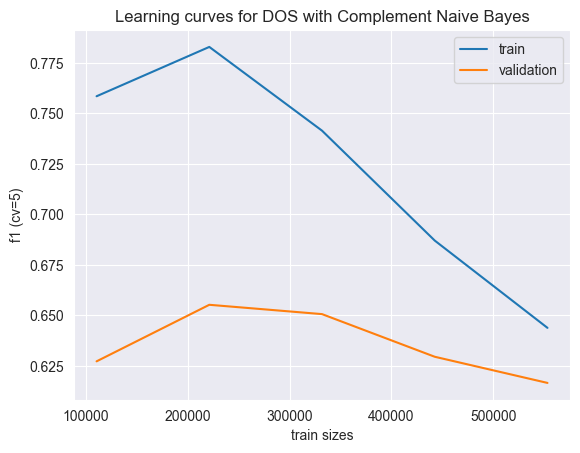

In [12]:
N_DOS_nb, train_score_DOS_nb, val_score_DOS_nb = learning_curve(nb, xtrain_DOS_lc, ytrain_DOS_lc, train_sizes=np.linspace(0.2, 1.0, 5), cv=5, scoring='f1', n_jobs=6)
plt.plot(N_DOS_nb, train_score_DOS_nb.mean(axis=1), label='train')
plt.plot(N_DOS_nb, val_score_DOS_nb.mean(axis=1), label='validation')
plt.title('Learning curves for DOS with Complement Naive Bayes')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=5)')
plt.legend()

In [14]:
dataframe_preprocessing(df_PortScan)
ytrain_PortScan_lc = df_PortScan['Bin Label']
xtrain_PortScan_lc = df_PortScan.drop(columns=['Bin Label', 'Label'])

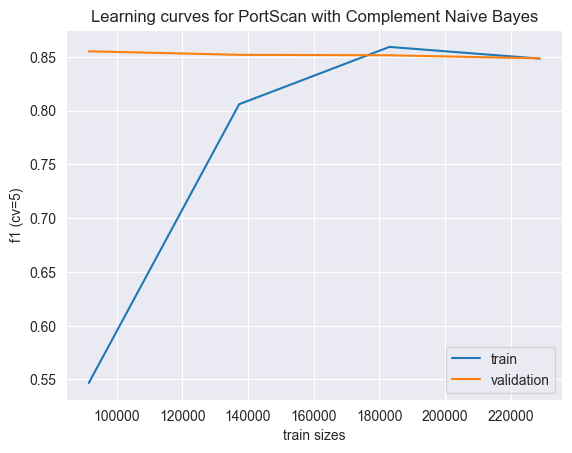

In [15]:
N_PortScan_nb, train_score_PortScan_nb, val_score_PortScan_nb = learning_curve(nb, xtrain_PortScan_lc, ytrain_PortScan_lc, train_sizes=np.linspace(0.2, 1.0, 5), cv=5, scoring='f1', n_jobs=6)
plt.plot(N_PortScan_nb, train_score_PortScan_nb.mean(axis=1), label='train')
plt.plot(N_PortScan_nb, val_score_PortScan_nb.mean(axis=1), label='validation')
plt.title('Learning curves for PortScan with Complement Naive Bayes')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=5)')
plt.legend()

In [16]:
dataframe_preprocessing(df_BruteForce)
ytrain_BruteForce_lc = df_BruteForce['Bin Label']
xtrain_BruteForce_lc = df_BruteForce.drop(columns=['Bin Label', 'Label'])

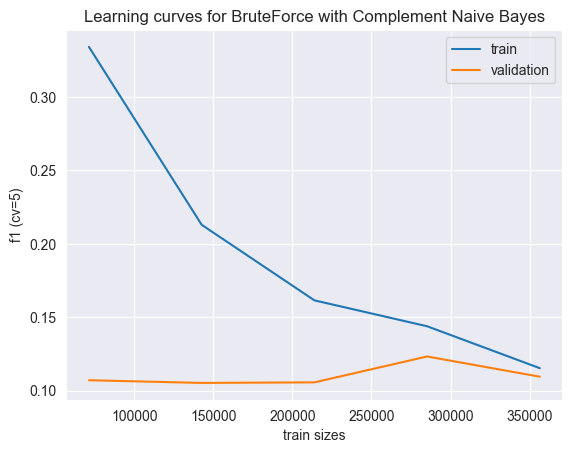

In [17]:
N_BruteForce_nb, train_score_BruteForce_nb, val_score_BruteForce_nb = learning_curve(nb, xtrain_BruteForce_lc, ytrain_BruteForce_lc, train_sizes=np.linspace(0.2, 1.0, 5), cv=5, scoring='f1', n_jobs=6)
plt.plot(N_BruteForce_nb, train_score_BruteForce_nb.mean(axis=1), label='train')
plt.plot(N_BruteForce_nb, val_score_BruteForce_nb.mean(axis=1), label='validation')
plt.title('Learning curves for BruteForce with Complement Naive Bayes')
plt.xlabel('train sizes')
plt.ylabel('f1 (cv=5)')
plt.legend()

The learning curves look odd. It seems that the larger the dataframe, the worse the results.
The computation time for Baysian classifiers is very low. Therefore, two tests will be performed for each classifier. One with a subset of a hundred thousand lines, and the other with a dozen thousand.

In [5]:
nb_to_optimize = ComplementNB()
nb_params = {
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001],
    'norm':[False, True]
}

In [18]:
# dataframe_preprocessing(df_DOS)
df_mini_DOS = not_a_matter_of_size(df_DOS, 220000)
ytrain_mini_DOS_nb = df_mini_DOS['Bin Label']
xtrain_mini_DOS_nb = df_mini_DOS.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_3124\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [23]:
grid_search_nb_DOS = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_DOS.fit(xtrain_mini_DOS_nb, ytrain_mini_DOS_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [24]:
grid_search_nb_DOS.best_params_

{'alpha': 0.0001, 'norm': True}

In [25]:
grid_search_nb_DOS.best_score_

0.6732808173444225

In [22]:
df_mini_DOS = not_a_matter_of_size(df_DOS, 10000)
ytrain_mini_DOS_nb = df_mini_DOS['Bin Label']
xtrain_mini_DOS_nb = df_mini_DOS.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_8640\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [23]:
grid_search_nb_DOS = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_DOS.fit(xtrain_mini_DOS_nb, ytrain_mini_DOS_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [24]:
grid_search_nb_DOS.best_params_

{'alpha': 1, 'norm': True}

In [25]:
grid_search_nb_DOS.best_score_

0.6806187804296066

In [9]:
nb_to_optimize = ComplementNB()
nb_params = {
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001],
    'norm':[False, True]
}

dataframe_preprocessing(df_PortScan)
df_mini_PortScan = not_a_matter_of_size(df_PortScan, 180000)
ytrain_mini_PortScan_nb = df_mini_PortScan['Bin Label']
xtrain_mini_PortScan_nb = df_mini_PortScan.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_12900\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [10]:
grid_search_nb_PortScan = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_PortScan.fit(xtrain_mini_PortScan_nb, ytrain_mini_PortScan_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [11]:
grid_search_nb_PortScan.best_params_

{'alpha': 1, 'norm': True}

In [12]:
grid_search_nb_PortScan.best_score_

0.8503799119591857

In [41]:
df_mini_PortScan = not_a_matter_of_size(df_PortScan, 10000)
ytrain_mini_PortScan_nb = df_mini_PortScan['Bin Label']
xtrain_mini_PortScan_nb = df_mini_PortScan.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_8640\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [42]:
grid_search_nb_PortScan = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_PortScan.fit(xtrain_mini_PortScan_nb, ytrain_mini_PortScan_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [43]:
grid_search_nb_PortScan.best_params_

{'alpha': 1, 'norm': False}

In [44]:
grid_search_nb_PortScan.best_score_

0.8449792016838849

In [45]:
df_grid_search_nb_PortScan = pd.DataFrame(grid_search_nb_PortScan.cv_results_)
df_grid_search_nb_PortScan

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_norm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016114,0.001421,0.006787,0.000747,1,False,"{'alpha': 1, 'norm': False}",0.846242,0.851880,0.843227,0.836542,0.847005,0.844979,0.005051,1
1,0.018988,0.001599,0.008956,0.001630,1,True,"{'alpha': 1, 'norm': True}",0.838880,0.847976,0.844834,0.834652,0.850901,0.843449,0.005936,8
2,0.020938,0.002320,0.009367,0.001714,0.1,False,"{'alpha': 0.1, 'norm': False}",0.846242,0.851880,0.843227,0.836542,0.847005,0.844979,0.005051,1
3,0.025080,0.003010,0.012098,0.001761,0.1,True,"{'alpha': 0.1, 'norm': True}",0.830090,0.839637,0.838759,0.828721,0.846682,0.836778,0.006631,9
4,0.022718,0.002158,0.011307,0.000924,0.01,False,"{'alpha': 0.01, 'norm': False}",0.846242,0.851880,0.843227,0.836542,0.847005,0.844979,0.005051,1
5,0.023094,0.002670,0.011366,0.001194,0.01,True,"{'alpha': 0.01, 'norm': True}",0.817847,0.831149,0.831208,0.822090,0.843145,0.829088,0.008737,10
6,0.023300,0.002545,0.011148,0.000705,0.001,False,"{'alpha': 0.001, 'norm': False}",0.846242,0.851880,0.843227,0.836542,0.847005,0.844979,0.005051,1
7,0.025126,0.004026,0.013186,0.002315,0.001,True,"{'alpha': 0.001, 'norm': True}",0.816041,0.819188,0.823180,0.806545,0.836473,0.820286,0.009782,11
8,0.027380,0.002872,0.015597,0.001315,0.0001,False,"{'alpha': 0.0001, 'norm': False}",0.846242,0.851880,0.843227,0.836542,0.847005,0.844979,0.005051,1
9,0.037382,0.012830,0.014902,0.002446,0.0001,True,"{'alpha': 0.0001, 'norm': True}",0.815741,0.808449,0.809942,0.804498,0.829287,0.813583,0.008642,12


In [24]:
nb_to_optimize = ComplementNB()
nb_params = {
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.0000001],
    'norm':[False, True]
}

dataframe_preprocessing(df_BruteForce)
df_mini_BruteForce = not_a_matter_of_size(df_BruteForce, 275000)
ytrain_mini_BruteForce_nb = df_mini_BruteForce['Bin Label']
xtrain_mini_BruteForce_nb = df_mini_BruteForce.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_12900\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [33]:
grid_search_nb_BruteForce = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_BruteForce.fit(xtrain_mini_BruteForce_nb, ytrain_mini_BruteForce_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [34]:
grid_search_nb_BruteForce.best_params_

{'alpha': 0.0001, 'norm': False}

In [35]:
grid_search_nb_BruteForce.best_score_

0.1339216740645261

In [36]:
df_grid_search_nb_BruteForce = pd.DataFrame(grid_search_nb_BruteForce.cv_results_)
df_grid_search_nb_BruteForce

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_norm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.909174,0.057422,0.142931,0.014363,1,False,"{'alpha': 1, 'norm': False}",0.159044,0.151744,0.150700,0.096171,0.096444,0.130820,0.028326,5
1,1.106183,0.129876,0.157621,0.055609,1,True,"{'alpha': 1, 'norm': True}",0.085951,0.085655,0.085428,0.085820,0.086145,0.085800,0.000246,6
2,0.953142,0.142784,0.146778,0.037402,0.1,False,"{'alpha': 0.1, 'norm': False}",0.160422,0.153236,0.151813,0.096290,0.096545,0.131661,0.028924,4
3,1.259151,0.223675,0.196816,0.146076,0.1,True,"{'alpha': 0.1, 'norm': True}",0.085780,0.085492,0.085285,0.085493,0.085793,0.085569,0.000194,7
4,1.027869,0.098358,0.139367,0.020590,0.01,False,"{'alpha': 0.01, 'norm': False}",0.161908,0.154539,0.152984,0.096386,0.096665,0.132496,0.029525,3
5,1.011670,0.062934,0.186672,0.107559,0.01,True,"{'alpha': 0.01, 'norm': True}",0.085640,0.085359,0.085136,0.085296,0.085617,0.085410,0.000193,8
6,1.230881,0.132722,0.265975,0.091156,0.001,False,"{'alpha': 0.001, 'norm': False}",0.163203,0.155707,0.154075,0.096528,0.096805,0.133264,0.030040,2
7,1.887098,0.675374,0.426888,0.261201,0.001,True,"{'alpha': 0.001, 'norm': True}",0.085465,0.085230,0.084994,0.085166,0.085483,0.085268,0.000185,9
8,1.819696,0.549148,0.597043,0.275046,0.0001,False,"{'alpha': 0.0001, 'norm': False}",0.164154,0.156677,0.155140,0.096703,0.096935,0.133922,0.030448,1
9,2.091789,0.507960,0.272403,0.101289,0.0001,True,"{'alpha': 0.0001, 'norm': True}",0.085300,0.085121,0.084874,0.085011,0.085400,0.085141,0.000190,10


In [31]:
df_mini_BruteForce = not_a_matter_of_size(df_BruteForce, 10000)
ytrain_mini_BruteForce_nb = df_mini_BruteForce['Bin Label']
xtrain_mini_BruteForce_nb = df_mini_BruteForce.drop(columns=['Bin Label', 'Label'])

C:\Users\Comar\AppData\Local\Temp\ipykernel_8640\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [32]:
grid_search_nb_BruteForce = GridSearchCV(nb_to_optimize, nb_params, cv=5, scoring='f1', n_jobs=6)
grid_search_nb_BruteForce.fit(xtrain_mini_BruteForce_nb, ytrain_mini_BruteForce_nb)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=6,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-07],
                         'norm': [False, True]},
             scoring='f1')

In [33]:
grid_search_nb_BruteForce.best_params_

{'alpha': 1e-05, 'norm': False}

In [34]:
grid_search_nb_BruteForce.best_score_

0.10833133362164901

In [35]:
df_grid_search_nb_BruteForce = pd.DataFrame(grid_search_nb_BruteForce.cv_results_)
df_grid_search_nb_BruteForce

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_norm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046605,0.017342,0.067526,0.051586,1,False,"{'alpha': 1, 'norm': False}",0.081006,0.094987,0.085492,0.127835,0.139326,0.105729,0.023467,6
1,0.062399,0.025669,0.032211,0.012818,1,True,"{'alpha': 1, 'norm': True}",0.090909,0.118208,0.115242,0.086713,0.088889,0.099992,0.013758,7
2,0.036564,0.004079,0.018880,0.003793,0.1,False,"{'alpha': 0.1, 'norm': False}",0.081346,0.095618,0.086050,0.128364,0.140113,0.106298,0.023567,5
3,0.035954,0.003771,0.020228,0.003957,0.1,True,"{'alpha': 0.1, 'norm': True}",0.089197,0.108867,0.110714,0.085106,0.087447,0.096266,0.011134,8
4,0.031167,0.004649,0.017607,0.004359,0.01,False,"{'alpha': 0.01, 'norm': False}",0.081690,0.096386,0.086614,0.128631,0.140113,0.106687,0.023378,4
5,0.025172,0.002855,0.011857,0.002185,0.01,True,"{'alpha': 0.01, 'norm': True}",0.118888,0.086592,0.086351,0.084239,0.086351,0.092484,0.013229,9
6,0.024472,0.001487,0.010800,0.001520,0.001,False,"{'alpha': 0.001, 'norm': False}",0.082504,0.097166,0.087302,0.128764,0.140909,0.107329,0.023271,3
7,0.024536,0.003209,0.012813,0.001326,0.001,True,"{'alpha': 0.001, 'norm': True}",0.117313,0.086532,0.085576,0.083727,0.085695,0.091769,0.012805,10
8,0.030179,0.004907,0.014632,0.001006,0.0001,False,"{'alpha': 0.0001, 'norm': False}",0.082739,0.097959,0.088117,0.128898,0.141230,0.107789,0.023130,2
9,0.037011,0.002099,0.035887,0.014090,0.0001,True,"{'alpha': 0.0001, 'norm': True}",0.110912,0.086411,0.085517,0.083614,0.085399,0.090371,0.010311,11


### Summary of observations :

In [2]:
# YOU CAN RUN THIS CELL TO SEE THE WHOLE DATAFRAME CORRECTLY !!!

resum_dict = {
    'Train set' : ['DOS', 'PortScan', 'BruteForce', 'DOS', 'PortScan', 'BruteForce', 'DOS', 'PortScan', 'BruteForce', 'mini_DOS', 'mini_PortScan', 'mini_BruteForce'],
    'Model' : ['KNN', 'KNN', 'KNN', 'RF', 'RF', 'RF', 'NB', 'NB', 'NB', 'NB', 'NB', 'NB'],
    'Train size' : [150000, 130000, 120000, 250000, 270000, 240000, 220000, 180000, 275000, 10000, 10000, 10000],
    'Optimal params' : [r'{n_neigh: 15 ; p: 1 ; weights: distance}', r'{n_neigh: 10 ; p: 2 ; weights: distance}', r'{n_neigh: 10 ; p: 1 ; weights: distance}', r'{criterion: entropy ; max_depth: 20 ; max_features: None ; n_estimators: 100}', r'{criterion: gini ; max_depth: 20 ; max_features: sqrt ; n_estimators: 200}', r'{criterion: gini ; max_depth: None ; max_features: None ; n_estimators: 100}', r'{alpha: 0.0001 ; norm: True}', r'{alpha: 1 ; norm: True}', r'{alpha: 0.0001 ; norm: False}', r'{alpha: 1 ; norm: True}', r'{alpha: 1 ; norm: False}', r'{alpha: 0.00001 ; norm: False}'],
    'Best f1-score' : [0.95, 0.99, 0.95, 0.97, 0.99, 0.99, 0.67, 0.85, 0.13, 0.68, 0.84, 0.11]
}
resum_df = pd.DataFrame(resum_dict)
resum_df

,Train set,Model,Train size,Optimal params,Best f1-score
0,DOS,KNN,150000,{n_neigh: 15 ; p: 1 ; weights: distance},0.95
1,PortScan,KNN,130000,{n_neigh: 10 ; p: 2 ; weights: distance},0.99
2,BruteForce,KNN,120000,{n_neigh: 10 ; p: 1 ; weights: distance},0.95
3,DOS,RF,250000,{criterion: entropy ; max_depth: 20 ; max_feat...,0.97
4,PortScan,RF,270000,{criterion: gini ; max_depth: 20 ; max_feature...,0.99
5,BruteForce,RF,240000,{criterion: gini ; max_depth: None ; max_featu...,0.99
6,DOS,NB,220000,{alpha: 0.0001 ; norm: True},0.67
7,PortScan,NB,180000,{alpha: 1 ; norm: True},0.85
8,BruteForce,NB,275000,{alpha: 0.0001 ; norm: False},0.13
9,mini_DOS,NB,10000,{alpha: 1 ; norm: True},0.68


# Testing phase

In [5]:
for i in [df_DOS, df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan]:
    dataframe_preprocessing(i) # RUN THIS CELL BEFORE ANY TEST !!!!!

# KNN

## KNN with DOS

In [8]:
DOS_vs_World_knn = not_a_matter_of_size(df_DOS, 150000)
world_vs_DOS_knn = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_DOS_vs_world_knn, x_world_vs_DOS_knn, y_DOS_vs_world_knn, y_world_vs_DOS_knn = my_train_test_split(DOS_vs_World_knn, world_vs_DOS_knn)

C:\Users\Comar\AppData\Local\Temp\ipykernel_15388\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [9]:
DOS_knn_opt = KNeighborsClassifier(n_neighbors=15, p=1, weights='distance', n_jobs=6)
DOS_knn_opt.fit(x_DOS_vs_world_knn, y_DOS_vs_world_knn)
y_pred_DOS_vs_world = DOS_knn_opt.predict(x_world_vs_DOS_knn)

In [10]:
DOS_vs_world_cl = classification_report(y_world_vs_DOS_knn, y_pred_DOS_vs_world)
print('Score =', DOS_knn_opt.score(x_world_vs_DOS_knn, y_world_vs_DOS_knn))
print('\nReport :\n', DOS_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_DOS_knn, y_pred_DOS_vs_world)) # Useless
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_DOS_knn, y_pred_DOS_vs_world)) # Useless

Score = 0.8802300451340986

Report :
               precision    recall  f1-score   support

           0       0.90      0.96      0.93   1302156
           1       0.76      0.55      0.63    304833

    accuracy                           0.88   1606989
   macro avg       0.83      0.75      0.78   1606989
weighted avg       0.87      0.88      0.87   1606989

mean squared error (MSE) : 0.120
coefficient de détermination (r^2) : 0.221


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below

[[1248243   53913]
 [ 138556  166277]]


<Axes: >

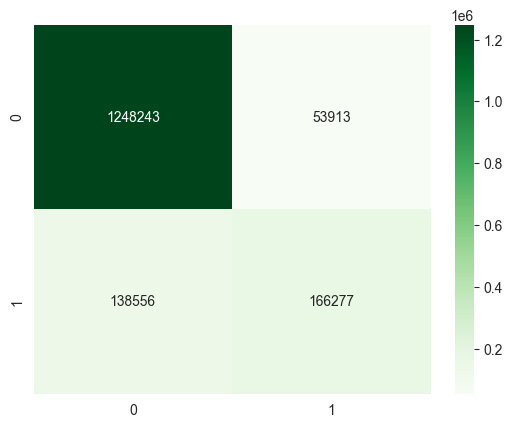

In [11]:
DOS_vs_world_knn_cm = confusion_matrix(y_world_vs_DOS_knn, y_pred_DOS_vs_world)
print(DOS_vs_world_knn_cm)
sns.heatmap(DOS_vs_world_knn_cm, annot=True, fmt='d', cmap='Greens')

## KNN with PortScan

In [12]:
PortScan_vs_World_knn = not_a_matter_of_size(df_PortScan, 130000)
world_vs_PortScan_knn = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_PortScan_vs_world_knn, x_world_vs_PortScan_knn, y_PortScan_vs_world_knn, y_world_vs_PortScan_knn = my_train_test_split(PortScan_vs_World_knn, world_vs_PortScan_knn)

C:\Users\Comar\AppData\Local\Temp\ipykernel_15388\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [13]:
PortScan_knn_opt = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance', n_jobs=6)
PortScan_knn_opt.fit(x_PortScan_vs_world_knn, y_PortScan_vs_world_knn)
y_pred_PortScan_vs_world = PortScan_knn_opt.predict(x_world_vs_PortScan_knn)

In [14]:
PortScan_vs_world_cl = classification_report(y_world_vs_PortScan_knn, y_pred_PortScan_vs_world)
print('Score =', PortScan_knn_opt.score(x_world_vs_PortScan_knn, y_world_vs_PortScan_knn))
print('\nReport :\n', PortScan_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_PortScan_knn, y_pred_PortScan_vs_world))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_PortScan_knn, y_pred_PortScan_vs_world))

Score = 0.8107045722330528

Report :
               precision    recall  f1-score   support

           0       0.83      0.97      0.89   1614547
           1       0.57      0.17      0.27    397752

    accuracy                           0.81   2012299
   macro avg       0.70      0.57      0.58   2012299
weighted avg       0.78      0.81      0.77   2012299

mean squared error (MSE) : 0.189
coefficient de détermination (r^2) : -0.194


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below

[[1562473   52074]
 [ 328845   68907]]


<Axes: >

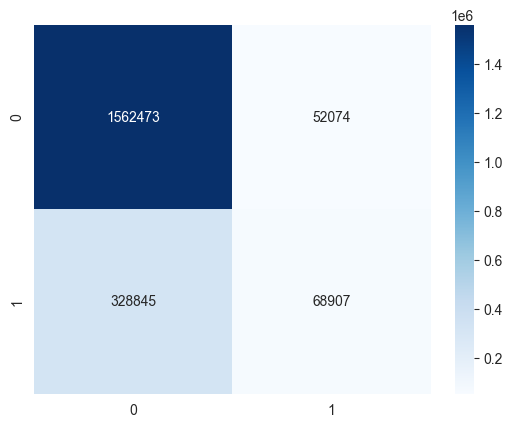

In [17]:
PortScan_vs_world_knn_cm = confusion_matrix(y_world_vs_PortScan_knn, y_pred_PortScan_vs_world)
print(PortScan_vs_world_knn_cm)
sns.heatmap(PortScan_vs_world_knn_cm, annot=True, fmt='d', cmap='Blues')

## KNN with BruteForce

In [18]:
BruteForce_vs_World_knn = not_a_matter_of_size(df_BruteForce, 120000)
world_vs_BruteForce_knn = pd.concat([df_DOS, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_BruteForce_vs_world_knn, x_world_vs_BruteForce_knn, y_BruteForce_vs_world_knn, y_world_vs_BruteForce_knn = my_train_test_split(BruteForce_vs_World_knn, world_vs_BruteForce_knn)

C:\Users\Comar\AppData\Local\Temp\ipykernel_15388\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [19]:
BruteForce_knn_opt = KNeighborsClassifier(n_neighbors=10, p=1, weights='distance', n_jobs=6)
BruteForce_knn_opt.fit(x_BruteForce_vs_world_knn, y_BruteForce_vs_world_knn)
y_pred_BruteForce_vs_world = BruteForce_knn_opt.predict(x_world_vs_BruteForce_knn)

In [20]:
BruteForce_vs_world_cl = classification_report(y_world_vs_BruteForce_knn, y_pred_BruteForce_vs_world)
print('Score =', BruteForce_knn_opt.score(x_world_vs_BruteForce_knn, y_world_vs_BruteForce_knn))
print('\nReport :\n', BruteForce_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_BruteForce_knn, y_pred_BruteForce_vs_world))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_BruteForce_knn, y_pred_BruteForce_vs_world))

Score = 0.692848468492781

Report :
               precision    recall  f1-score   support

           0       0.71      0.97      0.82   1310026
           1       0.25      0.02      0.04    542724

    accuracy                           0.69   1852750
   macro avg       0.48      0.50      0.43   1852750
weighted avg       0.57      0.69      0.59   1852750

mean squared error (MSE) : 0.307
coefficient de détermination (r^2) : -0.483


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below

[[1270624   39402]
 [ 529673   13051]]


<Axes: >

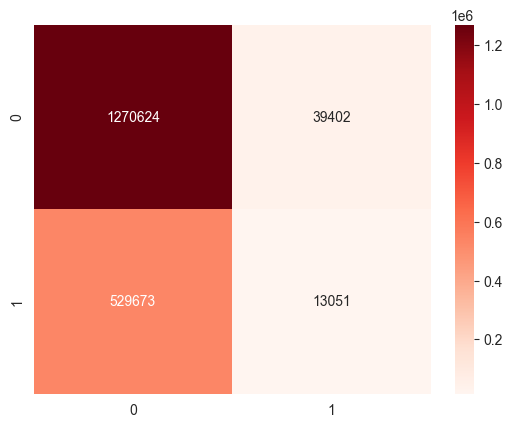

In [22]:
BruteForce_vs_world_knn_cm = confusion_matrix(y_world_vs_BruteForce_knn, y_pred_BruteForce_vs_world)
print(BruteForce_vs_world_knn_cm)
sns.heatmap(BruteForce_vs_world_knn_cm, annot=True, fmt='d', cmap='Reds')

## Analysing the Results of KNN model 

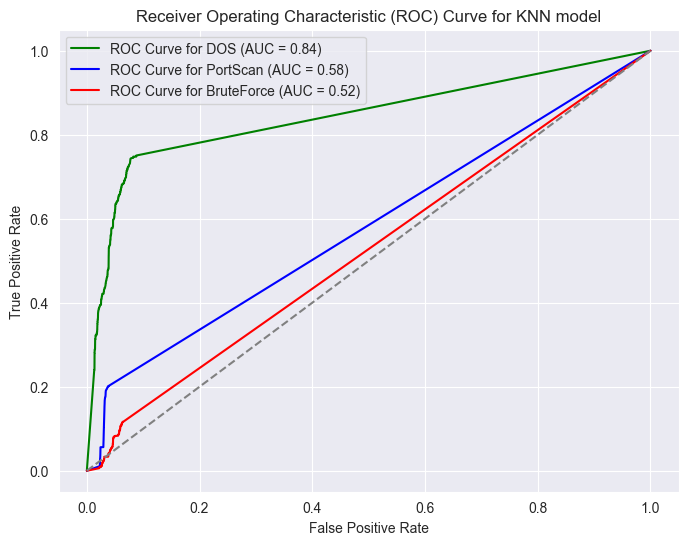

In [23]:
y_pp_DOS_knn = DOS_knn_opt.predict_proba(x_world_vs_DOS_knn)[:, 1]
fpr_DOS_knn, tpr_DOS_knn, th_DOS_knn = roc_curve(y_world_vs_DOS_knn, y_pp_DOS_knn)
auc_score_DOS_knn = roc_auc_score(y_world_vs_DOS_knn, y_pp_DOS_knn)

y_pp_PortScan_knn = PortScan_knn_opt.predict_proba(x_world_vs_PortScan_knn)[:, 1]
fpr_PortScan_knn, tpr_PortScan_knn, th_PortScan_knn = roc_curve(y_world_vs_PortScan_knn, y_pp_PortScan_knn)
auc_score_PortScan_knn = roc_auc_score(y_world_vs_PortScan_knn, y_pp_PortScan_knn)

y_pp_BruteForce_knn = BruteForce_knn_opt.predict_proba(x_world_vs_BruteForce_knn)[:, 1]
fpr_BruteForce_knn, tpr_BruteForce_knn, th_BruteForce_knn = roc_curve(y_world_vs_BruteForce_knn, y_pp_BruteForce_knn)
auc_score_BruteForce_knn = roc_auc_score(y_world_vs_BruteForce_knn, y_pp_BruteForce_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_DOS_knn, tpr_DOS_knn, color = 'green', label=f'ROC Curve for DOS (AUC = {auc_score_DOS_knn:.2f})')
plt.plot(fpr_PortScan_knn, tpr_PortScan_knn, color = 'blue', label=f'ROC Curve for PortScan (AUC = {auc_score_PortScan_knn:.2f})')
plt.plot(fpr_BruteForce_knn, tpr_BruteForce_knn, color = 'red', label=f'ROC Curve for BruteForce (AUC = {auc_score_BruteForce_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
pathII = r"Results/KNN/"
KNN_DOS_I = pd.read_csv(Path(pathII+'KNN_DOS_Results_I.csv'))
KNN_DOS_II = pd.read_csv(Path(pathII+'KNN_DOS_Results_II.csv'))
df_KNN_DOS = pd.concat([KNN_DOS_I, KNN_DOS_II], ignore_index=True)
KNN_BruteForce_I = pd.read_csv(Path(pathII+'KNN_BruteForce_Results_I.csv'))
KNN_BruteForce_II = pd.read_csv(Path(pathII+'KNN_BruteForce_Results_II.csv'))
df_KNN_BruteForce = pd.concat([KNN_BruteForce_I, KNN_BruteForce_II], ignore_index=True)
KNN_PortScan_I = pd.read_csv(Path(pathII+'KNN_PortScan_Results_I.csv'))
KNN_PortScan_II = pd.read_csv(Path(pathII+'KNN_PortScan_Results_II.csv'))
df_KNN_PortScan = pd.concat([KNN_PortScan_I, KNN_PortScan_II], ignore_index=True)

### Model trained with DOS dataset

Total number of false negative : (138556, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


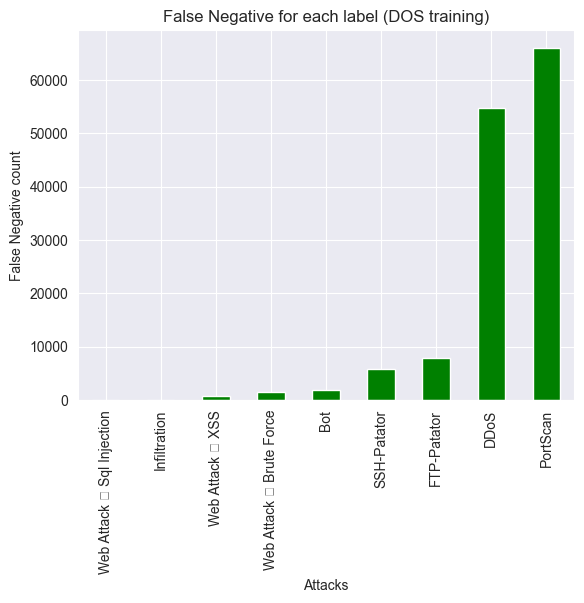

Label
PortScan                      66016
DDoS                          54716
FTP-Patator                    7904
SSH-Patator                    5872
Bot                            1912
Web Attack � Brute Force       1436
Web Attack � XSS                647
Infiltration                     35
Web Attack � Sql Injection       18
Name: count, dtype: int64

In [64]:
FN_DOS_KNN = df_KNN_DOS[(df_KNN_DOS['Bin Label']==1) & (df_KNN_DOS['predicted Label']==0)]
print('Total number of false negative :', FN_DOS_KNN.shape)
fn_Label_count = FN_DOS_KNN.value_counts('Label')
fn_Label_count.sort_values().plot(kind='bar', color='green')
plt.title('False Negative for each label (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


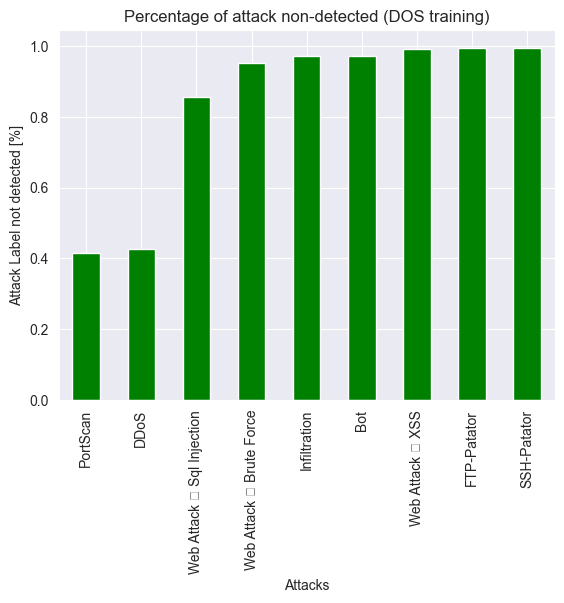

SSH-Patator                   0.995761
FTP-Patator                   0.995717
Web Attack � XSS              0.992331
Bot                           0.972533
Infiltration                  0.972222
Web Attack � Brute Force      0.952887
Web Attack � Sql Injection    0.857143
DDoS                          0.427379
PortScan                      0.415378
Name: count, dtype: float64

In [63]:
dos_knn_com_index = lab_count.index.intersection(fn_Label_count.index)
dos_knn_res = (fn_Label_count[dos_knn_com_index] / lab_count[dos_knn_com_index])
dos_knn_res.sort_values().plot(kind='bar', color='green')
plt.title('Percentage of attack non-detected (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
dos_knn_res.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


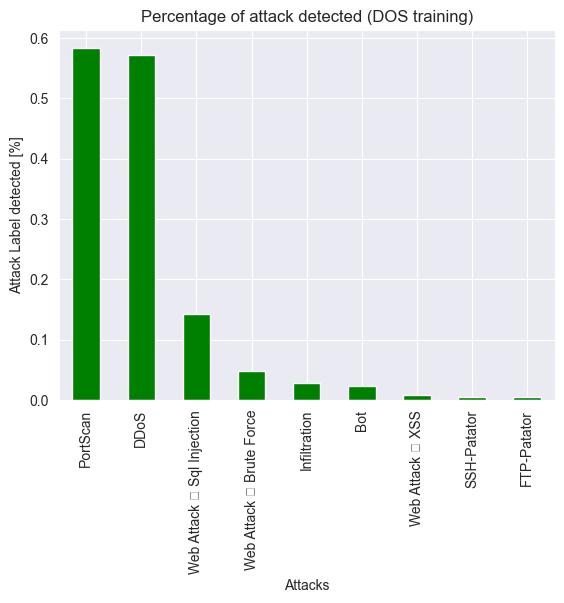

PortScan                      0.583829
DDoS                          0.572606
Web Attack � Sql Injection    0.142857
Web Attack � Brute Force      0.047113
Infiltration                  0.027778
Bot                           0.022380
Web Attack � XSS              0.007669
SSH-Patator                   0.004239
FTP-Patator                   0.003905
Name: count, dtype: float64

In [75]:
TP_DOS_KNN = df_KNN_DOS[(df_KNN_DOS['Bin Label']==1) & (df_KNN_DOS['predicted Label']==1)]
tp_Label_count_dos = TP_DOS_KNN.value_counts('Label')
dos_knn_tp_index = lab_count.index.intersection(tp_Label_count_dos.index)
tp_dos_knn_res = (tp_Label_count_dos[dos_knn_tp_index] / lab_count[dos_knn_tp_index])
tp_dos_knn_res.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Percentage of attack detected (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_dos_knn_res.sort_values(ascending=False)

PortScan and DDOS are partially detected. BruteForce, XSS, Bot and Infiltration are not.

Now it's time to analyze the correlations between the various attacks in order to explain the detections and non-detections. Partially detected and not detected attacks will be visualized on the table. The characteristics chosen are based on the correlation tables of the characteristics present at the end of the visualization. The reference table is chosen according to the training subset. The benign actions are not displayed because they are so over-represented that the other classes are hidden.


In [9]:
df_knn_anal_dos_ = pd.concat([df_DOS, df_DDOS, df_BruteForce, df_PortScan], axis=0, ignore_index=True)
df_knn_anal_dos = df_knn_anal_dos_[df_knn_anal_dos_['Label'] != 'BENIGN']

Text(0.5, 1.0, 'Backward Header Length in comparison with packets in the backward subflow')

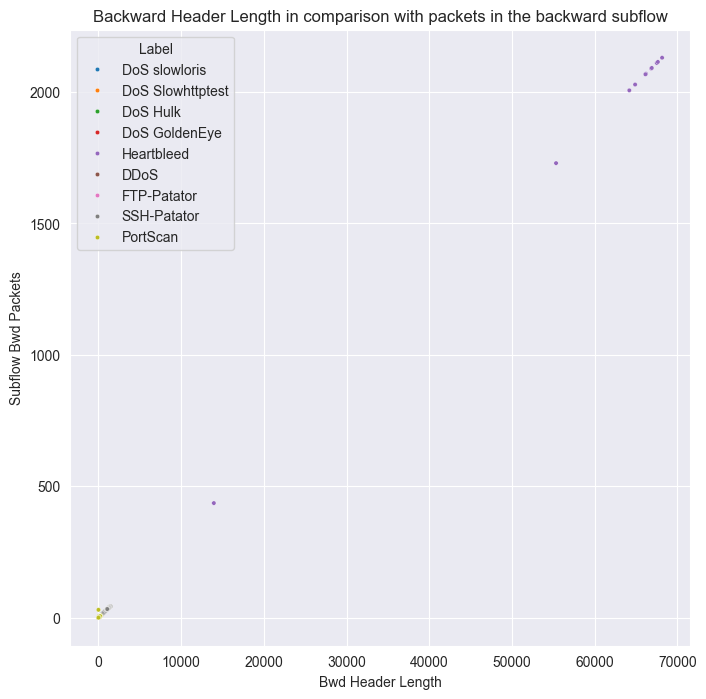

In [21]:
plt.figure(figsize=(8,8))
sns.scatterplot(x="Bwd Header Length", y="Subflow Bwd Packets", hue="Label", data=df_knn_anal_dos, s=10)
plt.title('Backward Header Length in comparison with packets in the backward subflow')

Most of the attacks are grouped together. HeartBleed is an outlier

<Axes: title={'center': 'Flow duration in comparison with total frontward IAT'}, xlabel='Flow Duration', ylabel='Fwd IAT Total'>

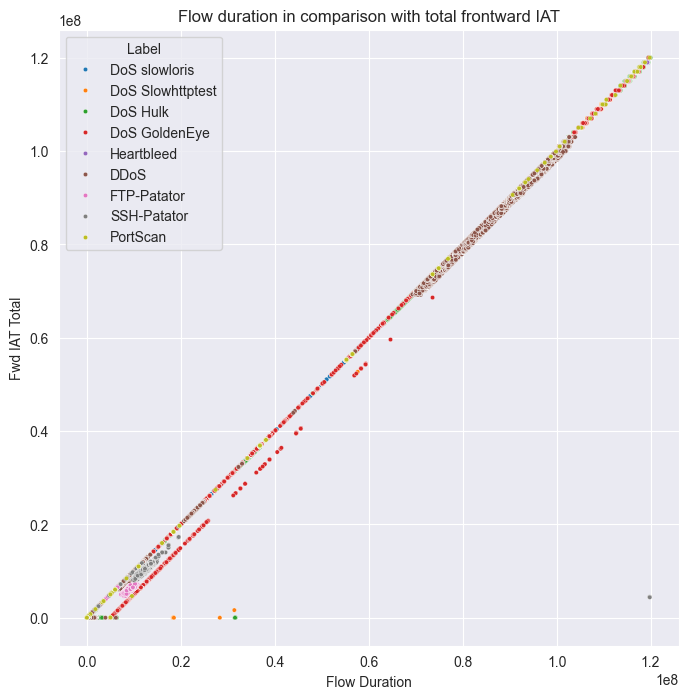

In [22]:
plt.figure(figsize=(8,8))
plt.title('Flow duration in comparison with total frontward IAT')
sns.scatterplot(x="Flow Duration", y="Fwd IAT Total", hue="Label", data=df_knn_anal_dos, s=10)

Better Separation between the attacks. Some of them form linear clusters, like DOS GoldenEye (red) or FTP-Patator (dark purple).
The two features are linear.

<Axes: title={'center': 'Total frontward packets in comparison with the frontward activ packet'}, xlabel='Total Fwd Packets', ylabel='act_data_pkt_fwd'>

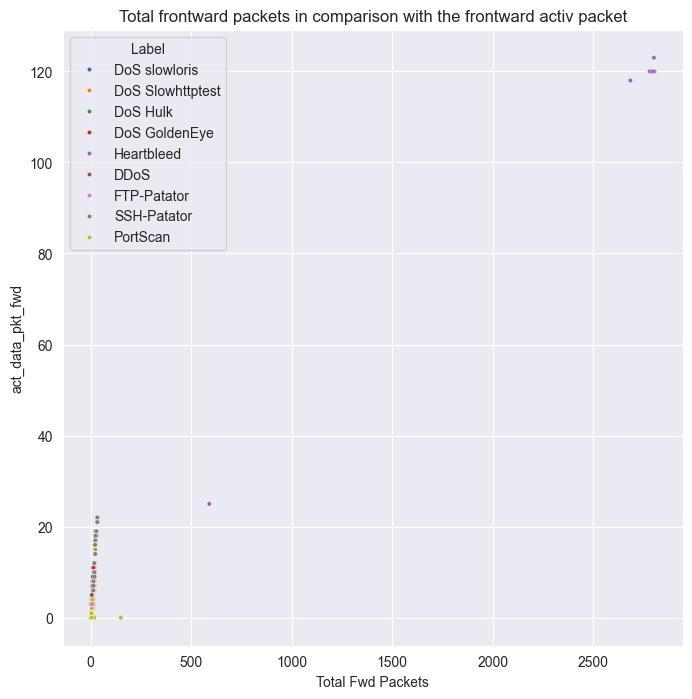

In [23]:
plt.figure(figsize=(8,8))
plt.title('Total frontward packets in comparison with the frontward activ packet')
sns.scatterplot(x="Total Fwd Packets", y="act_data_pkt_fwd", hue="Label", data=df_knn_anal_dos, s=10)

Again, heatBleed is an outlier. Some attacks form very small clusters (yellow and pale violet)


<Axes: title={'center': 'Mean backward Packet length in comparison with the average backward segment size'}, xlabel='Bwd Packet Length Mean', ylabel='Avg Bwd Segment Size'>

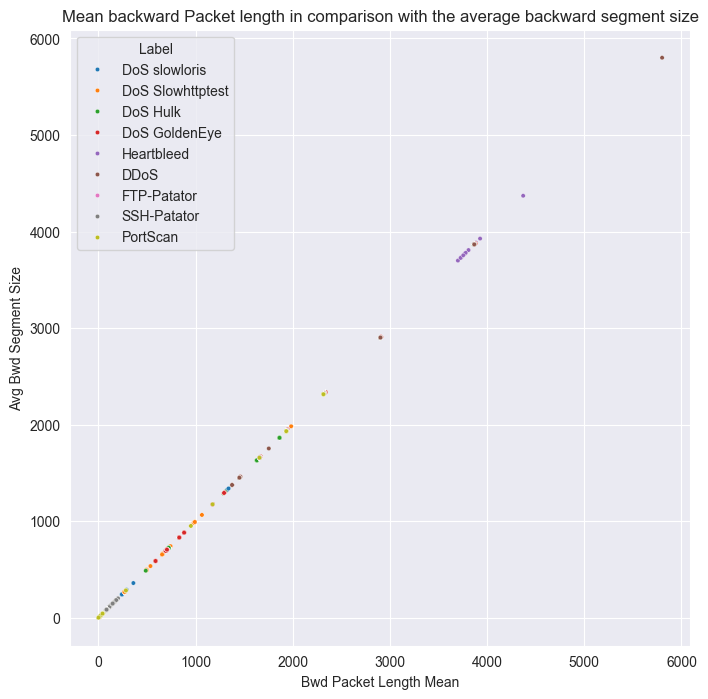

In [24]:
plt.figure(figsize=(8,8))
plt.title('Mean backward Packet length in comparison with the average backward segment size')
sns.scatterplot(x="Bwd Packet Length Mean", y="Avg Bwd Segment Size", hue="Label", data=df_knn_anal_dos, s=10)

### Model trained with PortScan dataset

Total number of false negative : (328845, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


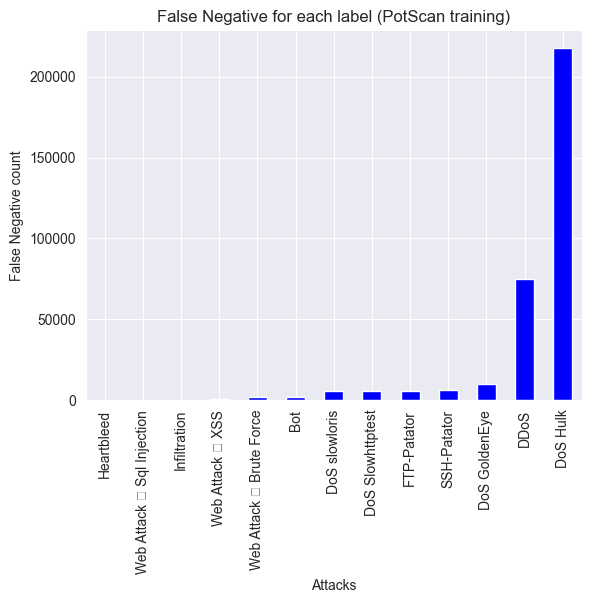

Label
DoS Hulk                      217926
DDoS                           74873
DoS GoldenEye                   9727
SSH-Patator                     5821
FTP-Patator                     5600
DoS Slowhttptest                5497
DoS slowloris                   5276
Bot                             1914
Web Attack � Brute Force        1497
Web Attack � XSS                 646
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [62]:
FN_PortScan_KNN = df_KNN_PortScan[(df_KNN_PortScan['Bin Label']==1) & (df_KNN_PortScan['Predicted Label']==0)]
print('Total number of false negative :', FN_PortScan_KNN.shape)
fn_Label_count_ports = FN_PortScan_KNN.value_counts('Label')
fn_Label_count_ports.sort_values().plot(kind='bar', color='blue')
plt.title('False Negative for each label (PotScan training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count_ports.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


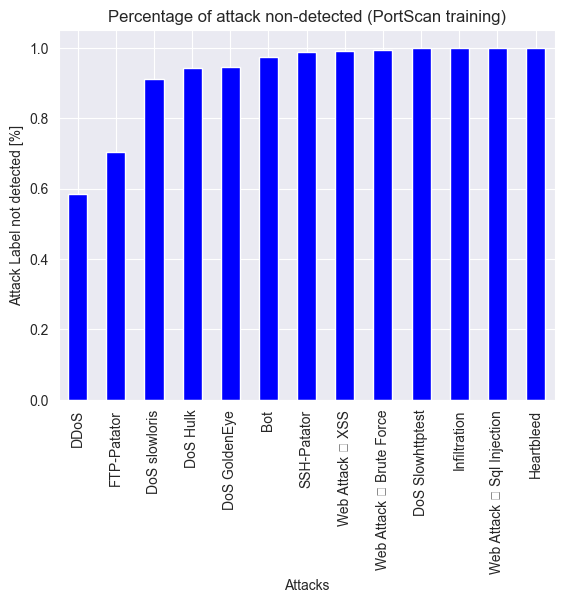

Infiltration                  1.000000
Web Attack � Sql Injection    1.000000
Heartbleed                    1.000000
DoS Slowhttptest              0.999636
Web Attack � Brute Force      0.993364
Web Attack � XSS              0.990798
SSH-Patator                   0.987112
Bot                           0.973550
DoS GoldenEye                 0.945011
DoS Hulk                      0.943105
DoS slowloris                 0.910283
FTP-Patator                   0.705467
DDoS                          0.584822
Name: count, dtype: float64

In [61]:
ports_knn_com_index = lab_count.index.intersection(fn_Label_count_ports.index)
ports_knn_res = (fn_Label_count_ports[ports_knn_com_index] / lab_count[ports_knn_com_index])
ports_knn_res.sort_values().plot(kind='bar', color='blue')
plt.title('Percentage of attack non-detected (PortScan training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
ports_knn_res.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


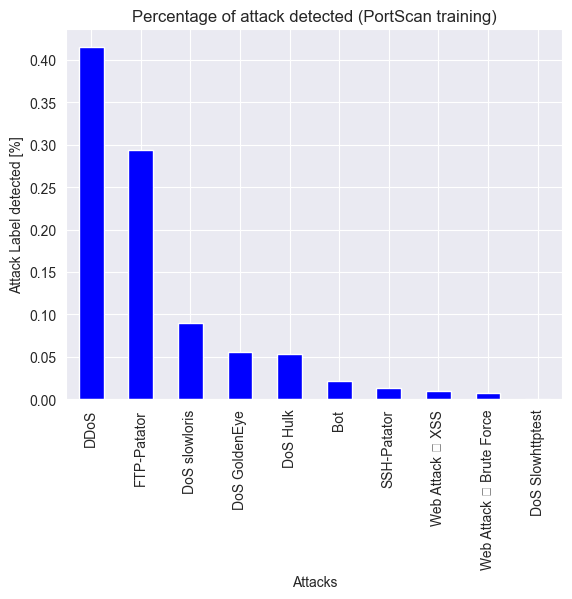

DDoS                        0.415162
FTP-Patator                 0.294155
DoS slowloris               0.089717
DoS GoldenEye               0.054989
DoS Hulk                    0.052789
Bot                         0.021363
SSH-Patator                 0.012888
Web Attack � XSS            0.009202
Web Attack � Brute Force    0.006636
DoS Slowhttptest            0.000364
Name: count, dtype: float64

In [76]:
TP_PortScan_KNN = df_KNN_PortScan[(df_KNN_PortScan['Bin Label']==1) & (df_KNN_PortScan['Predicted Label']==1)]
tp_Label_count_ports = TP_PortScan_KNN.value_counts('Label')
ports_knn_tp_index = lab_count.index.intersection(tp_Label_count_ports.index)
tp_ports_knn_res = (tp_Label_count_ports[ports_knn_tp_index] / lab_count[ports_knn_tp_index])
tp_ports_knn_res.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Percentage of attack detected (PortScan training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_ports_knn_res.sort_values(ascending=False)

In [15]:
df_knn_anal_PortScan_ = pd.concat([df_WebAttack, df_DDOS, df_BruteForce, df_PortScan], axis=0, ignore_index=True)
df_knn_anal_PortScan = df_knn_anal_PortScan_[df_knn_anal_PortScan_['Label'] != 'BENIGN']

<Axes: title={'center': 'Flow duration in comparison with total frontward IAT'}, xlabel='Flow Duration', ylabel='Fwd IAT Total'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


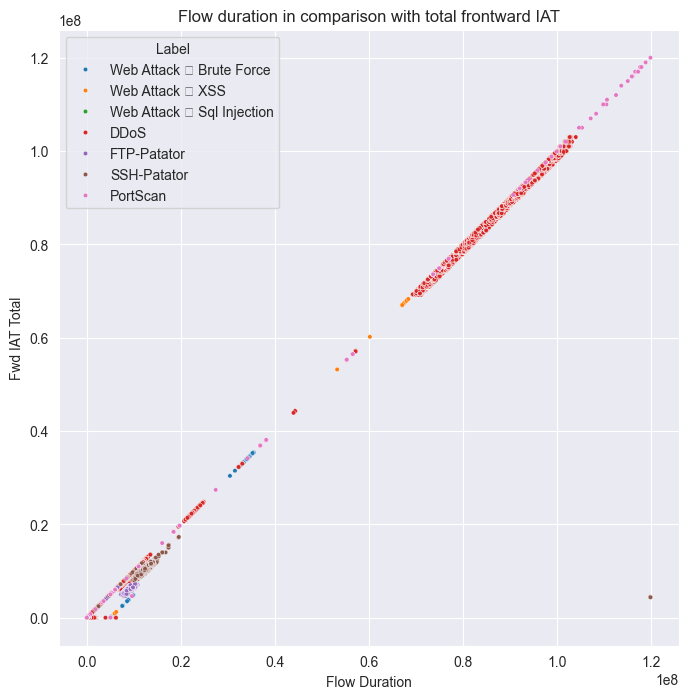

In [25]:
plt.figure(figsize=(8,8))
plt.title('Flow duration in comparison with total frontward IAT')
sns.scatterplot(x="Flow Duration", y="Fwd IAT Total", hue="Label", data=df_knn_anal_PortScan, s=10)

Red (DDOS) and Purple (PortScan) Clusters in the same place. The two features are linear


<Axes: title={'center': 'Total frontward packets in comparison with frontward packets in subflow'}, xlabel='Total Fwd Packets', ylabel='Subflow Fwd Packets'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


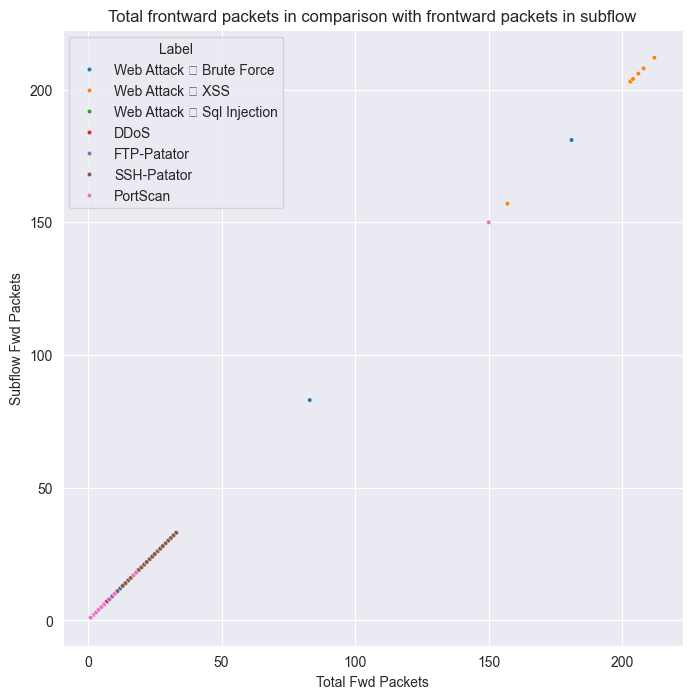

In [26]:
plt.figure(figsize=(8,8))
plt.title('Total frontward packets in comparison with frontward packets in subflow')
sns.scatterplot(x="Total Fwd Packets", y="Subflow Fwd Packets", hue="Label", data=df_knn_anal_PortScan, s=10)

WebAttack-XSS has outliers in the upper right corner. 


<Axes: title={'center': 'Packet length mean in comparison with the average packet size'}, xlabel='Packet Length Mean', ylabel='Average Packet Size'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


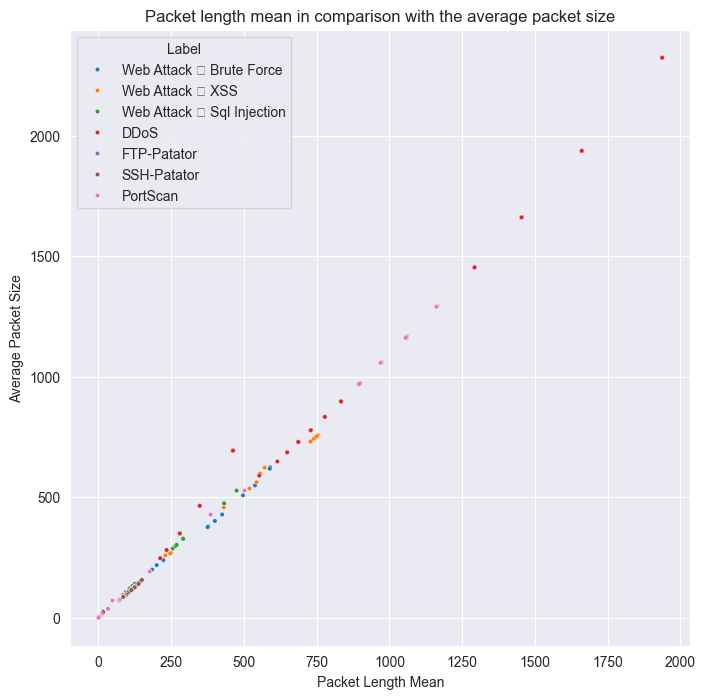

In [27]:
plt.figure(figsize=(8,8))
plt.title('Packet length mean in comparison with the average packet size')
sns.scatterplot(x="Packet Length Mean", y="Average Packet Size", hue="Label", data=df_knn_anal_PortScan, s=10)

For those two features, the classes are more scattered. 

<Axes: title={'center': 'maximum inter-arrival interval between flow packets in comparison with maximum inactive flow time'}, xlabel='Flow IAT Max', ylabel='Idle Max'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


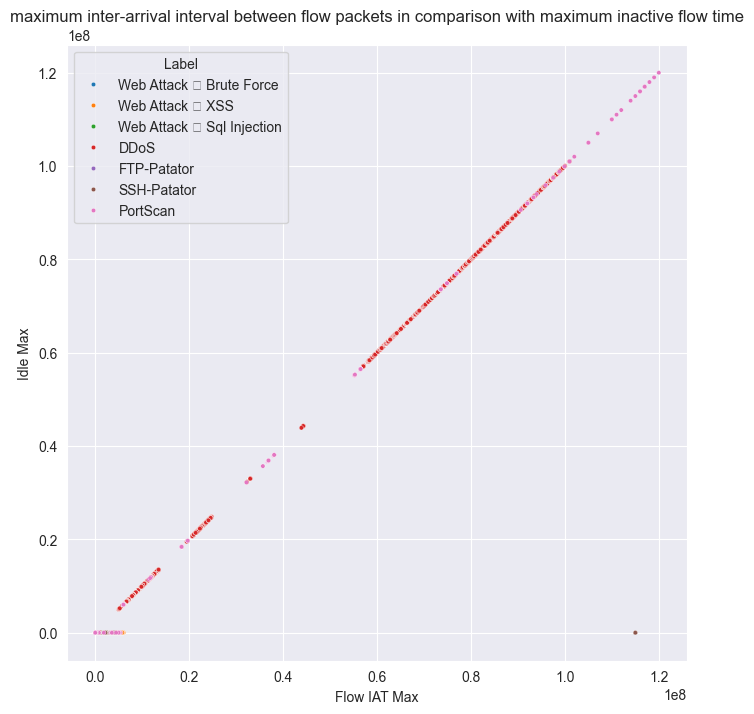

In [28]:
plt.figure(figsize=(8,8))
plt.title('maximum inter-arrival interval between flow packets in comparison with maximum inactive flow time')
sns.scatterplot(x="Flow IAT Max", y="Idle Max", hue="Label", data=df_knn_anal_PortScan, s=10)

Purple (PortScan), orange (XSS) and red (DDOS) form a linear clusters. Other types of attack have a y-axis value of 0.


### Model trained with BruteForce dataset

Total number of false negative : (529673, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


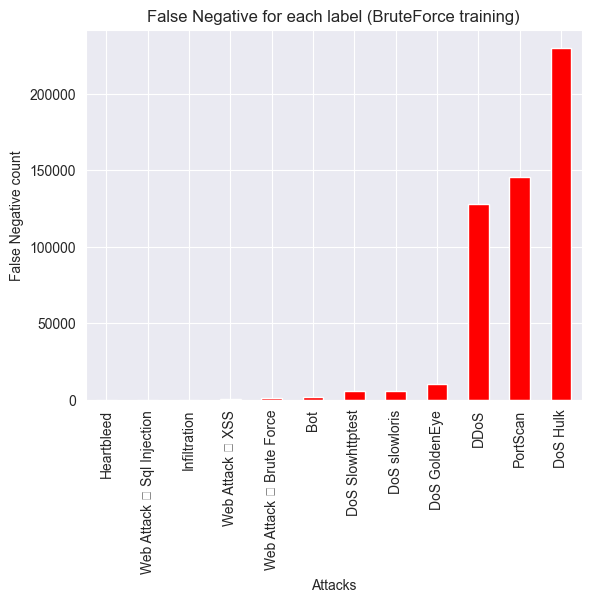

Label
DoS Hulk                      230122
PortScan                      145960
DDoS                          128020
DoS GoldenEye                  10289
DoS slowloris                   5678
DoS Slowhttptest                5499
Bot                             1955
Web Attack � Brute Force        1441
Web Attack � XSS                 649
Infiltration                      36
Web Attack � Sql Injection        13
Heartbleed                        11
Name: count, dtype: int64

In [66]:
FN_BruteForce_KNN = df_KNN_BruteForce[(df_KNN_BruteForce['Bin Label']==1) & (df_KNN_BruteForce['Predicted Label']==0)]
print('Total number of false negative :', FN_BruteForce_KNN.shape)
fn_Label_count_brute = FN_BruteForce_KNN.value_counts('Label')
fn_Label_count_brute.sort_values().plot(kind='bar', color='red')
plt.title('False Negative for each label (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count_brute.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


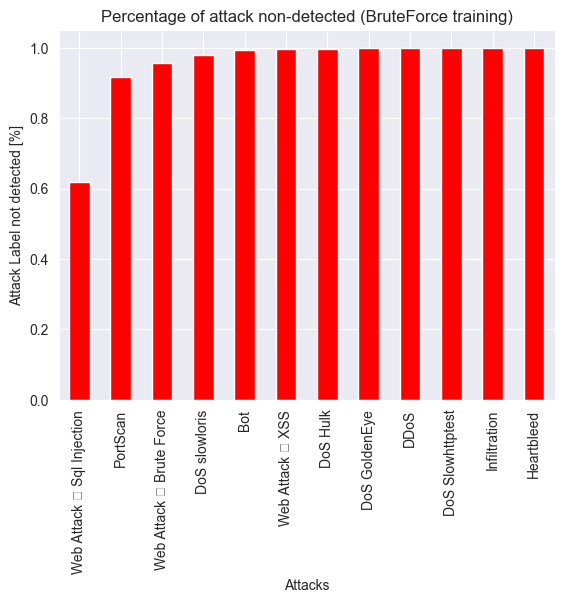

DoS Slowhttptest              1.000000
Infiltration                  1.000000
Heartbleed                    1.000000
DDoS                          0.999945
DoS GoldenEye                 0.999611
DoS Hulk                      0.995884
Web Attack � XSS              0.995399
Bot                           0.994405
DoS slowloris                 0.979641
Web Attack � Brute Force      0.956204
PortScan                      0.918392
Web Attack � Sql Injection    0.619048
Name: count, dtype: float64

In [67]:
brute_knn_com_index = lab_count.index.intersection(fn_Label_count_brute.index)
brute_knn_res = (fn_Label_count_brute[brute_knn_com_index] / lab_count[brute_knn_com_index])
brute_knn_res.sort_values().plot(kind='bar', color='red')
plt.title('Percentage of attack non-detected (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
brute_knn_res.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


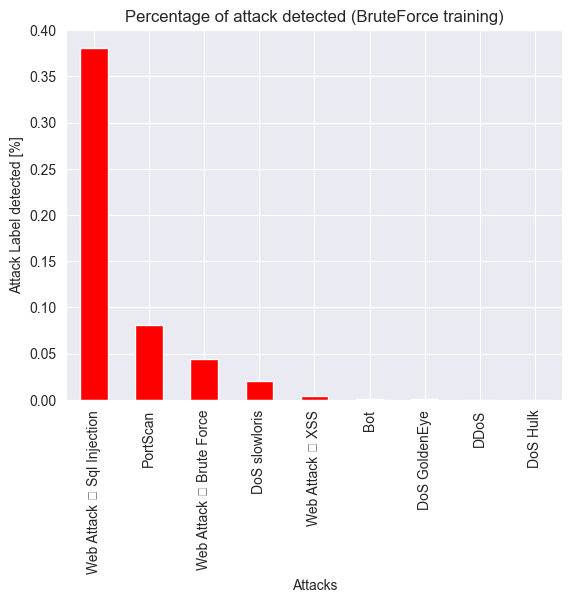

Web Attack � Sql Injection    0.380952
PortScan                      0.080815
Web Attack � Brute Force      0.043796
DoS slowloris                 0.020359
Web Attack � XSS              0.004601
Bot                           0.000509
DoS GoldenEye                 0.000389
DDoS                          0.000039
DoS Hulk                      0.000009
Name: count, dtype: float64

In [77]:
TP_BruteForce_KNN = df_KNN_BruteForce[(df_KNN_BruteForce['Bin Label']==1) & (df_KNN_BruteForce['Predicted Label']==1)]
tp_Label_count_brutes = TP_BruteForce_KNN.value_counts('Label')
brutes_knn_tp_index = lab_count.index.intersection(tp_Label_count_brutes.index)
tp_brutes_knn_res = (tp_Label_count_brutes[brutes_knn_tp_index] / lab_count[brutes_knn_tp_index])
tp_brutes_knn_res.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Percentage of attack detected (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_brutes_knn_res.sort_values(ascending=False)

In [6]:
df_knn_anal_BF_ = pd.concat([df_WebAttack, df_DDOS, df_BruteForce, df_PortScan], axis=0, ignore_index=True)
df_knn_anal_BF = df_knn_anal_BF_[df_knn_anal_BF_['Label'] != 'BENIGN']

<Axes: title={'center': 'Total frontward packets in comparison with frontward packets in subflow'}, xlabel='Total Fwd Packets', ylabel='Subflow Fwd Packets'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


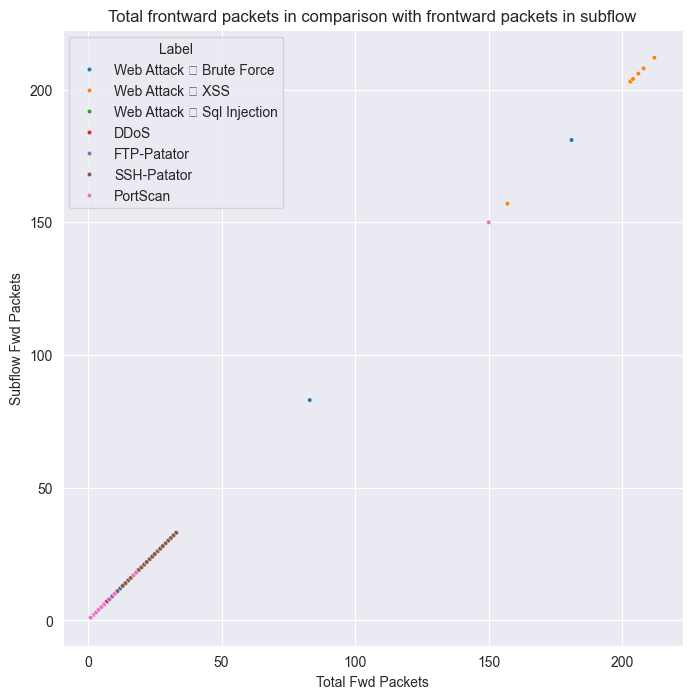

In [31]:
plt.figure(figsize=(8,8))
plt.title('Total frontward packets in comparison with frontward packets in subflow')
sns.scatterplot(x="Total Fwd Packets", y="Subflow Fwd Packets", hue="Label", data=df_knn_anal_BF, s=10)

<Axes: title={'center': 'Total frontward packets in comparison with total backward packets'}, xlabel='Total Fwd Packets', ylabel='Total Backward Packets'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


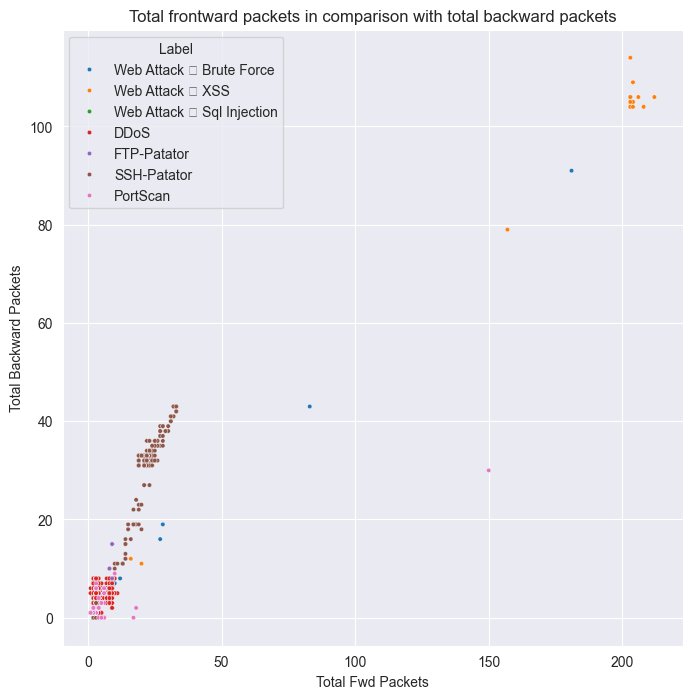

In [32]:
plt.figure(figsize=(8,8))
plt.title('Total frontward packets in comparison with total backward packets')
sns.scatterplot(x="Total Fwd Packets", y="Total Backward Packets", hue="Label", data=df_knn_anal_BF, s=10)

SSH-Patator and XSS form two distinct clusters. The others are grouped together in the bottom left-hand corner.


<Axes: title={'center': 'Flow duration in comparison with total frontward IAT'}, xlabel='Flow Duration', ylabel='Fwd IAT Total'>

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  func(*args, **kwargs)
C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


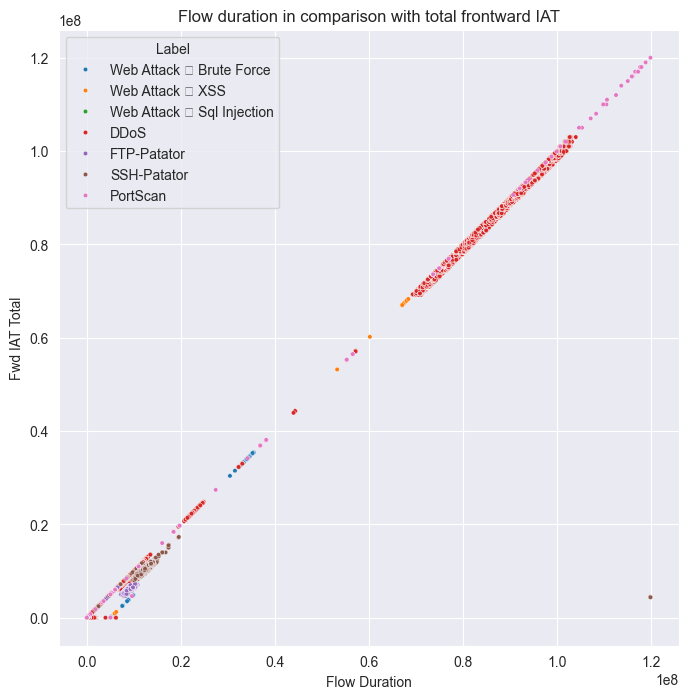

In [33]:
plt.figure(figsize=(8,8))
plt.title('Flow duration in comparison with total frontward IAT')
sns.scatterplot(x="Flow Duration", y="Fwd IAT Total", hue="Label", data=df_knn_anal_BF, s=10)

Linear clusters

Table of requests with RST flag and without ECE flag

In [17]:
df_rst = df_knn_anal_BF_[(df_knn_anal_BF_['RST Flag Count'] == 1)&(df_knn_anal_BF_['ECE Flag Count'] == 0)]
print('No request with only a RST flag --> \n')
df_rst['Label'].value_counts()

No request with only a RST flag --> 


Series([], Name: count, dtype: int64)

Table of requests with ECE flag and without RST flag

In [18]:
df_ece = df_knn_anal_BF_[(df_knn_anal_BF_['ECE Flag Count'] == 1)&(df_knn_anal_BF_['RST Flag Count'] == 0)]
print("Just one 'BENIGN' request with only a ECE flag --> \n")
df_ece['Label'].value_counts()

Just one 'BENIGN' request with only a ECE flag --> 


Label
BENIGN    1
Name: count, dtype: int64

Table of requests with RST flag and ECE flag

In [19]:
df_ece_rst = df_knn_anal_BF_[(df_knn_anal_BF_['ECE Flag Count'] == 1)&(df_knn_anal_BF_['RST Flag Count'] == 1)]
print("254'BENIGN' requests with both flags --> \n")
df_ece_rst['Label'].value_counts()

254'BENIGN' requests with both flags --> 


Label
BENIGN    254
Name: count, dtype: int64

Table of requests with no RST and ECE flags

In [15]:
df_Flag_None = df_knn_anal_BF_[(df_knn_anal_BF_['ECE Flag Count'] == 0)&(df_knn_anal_BF_['RST Flag Count'] == 0)]
df_Flag_None['Label'].value_counts()

Label
BENIGN                        824587
PortScan                      158804
DDoS                          128025
FTP-Patator                     7935
SSH-Patator                     5897
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: count, dtype: int64

# RandomForest

## DOS with RandomForest

In [8]:
DOS_vs_World_rf = not_a_matter_of_size(df_DOS, 250000)
world_vs_DOS_rf = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_DOS_vs_world_rf, x_world_vs_DOS_rf, y_DOS_vs_world_rf, y_world_vs_DOS_rf = my_train_test_split(DOS_vs_World_rf, world_vs_DOS_rf)

C:\Users\Comar\AppData\Local\Temp\ipykernel_8700\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [9]:
DOS_rf_opt = RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None, n_estimators=100, n_jobs=6)
DOS_rf_opt.fit(x_DOS_vs_world_rf, y_DOS_vs_world_rf)
y_pred_DOS_vs_world_rf = DOS_rf_opt.predict(x_world_vs_DOS_rf)

In [10]:
rf_DOS_vs_world_cl = classification_report(y_world_vs_DOS_rf, y_pred_DOS_vs_world_rf)
print('Score =', DOS_rf_opt.score(x_world_vs_DOS_rf, y_world_vs_DOS_rf))
print('\nReport :\n', rf_DOS_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_DOS_rf, y_pred_DOS_vs_world_rf))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_DOS_rf, y_pred_DOS_vs_world_rf))

Score = 0.8104809678224306

Report :
               precision    recall  f1-score   support

           0       0.81      1.00      0.90   1302156
           1       0.53      0.01      0.01    304833

    accuracy                           0.81   1606989
   macro avg       0.67      0.50      0.45   1606989
weighted avg       0.76      0.81      0.73   1606989

mean squared error (MSE) : 0.190
coefficient de détermination (r^2) : -0.233


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below.
       

[[1300265    1891]
 [ 302664    2169]]


<Axes: >

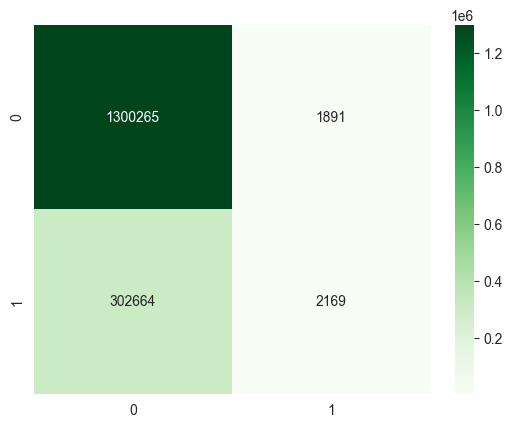

In [11]:
DOS_vs_world_rf_cm = confusion_matrix(y_world_vs_DOS_rf, y_pred_DOS_vs_world_rf)
print(DOS_vs_world_rf_cm)
sns.heatmap(DOS_vs_world_rf_cm, annot=True, fmt='d', cmap='Greens')

In [53]:
DOS_rf_features = pd.DataFrame(DOS_rf_opt.feature_importances_, index=x_world_vs_DOS_rf.columns)
DOS_rf_features.to_csv('DOS_rf_features.csv', index=True)

,0
Destination Port,0.043477
Flow Duration,0.001231
Total Fwd Packets,0.000104
Total Backward Packets,0.000814
Total Length of Fwd Packets,0.000349
...,...
Active Min,0.000164
Idle Mean,0.000372
Idle Std,0.000024
Idle Max,0.000223


In [13]:
world_vs_DOS_rf['Predicted Label'] = y_pred_DOS_vs_world_rf
dos_rf_midindex = len(world_vs_DOS_rf)//2
world_vs_DOS_rf_I = world_vs_DOS_rf.iloc[:dos_rf_midindex]
world_vs_DOS_rf_II = world_vs_DOS_rf.iloc[dos_rf_midindex:]
world_vs_DOS_rf_I.to_csv('RF_DOS_Results_I.csv', index=False)
world_vs_DOS_rf_II.to_csv('RF_DOS_Results_II.csv', index=False)

## PortScan with RandomForest

In [44]:
PortScan_vs_World_rf = not_a_matter_of_size(df_PortScan, 270000)
world_vs_PortScan_rf = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_PortScan_vs_world_rf, x_world_vs_PortScan_rf, y_PortScan_vs_world_rf, y_world_vs_PortScan_rf = my_train_test_split(PortScan_vs_World_rf, world_vs_PortScan_rf)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22016\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [15]:
PortScan_rf_opt = RandomForestClassifier(criterion='gini', max_depth=20, max_features='sqrt', n_estimators=200, n_jobs=6)
PortScan_rf_opt.fit(x_PortScan_vs_world_rf, y_PortScan_vs_world_rf)
y_pred_PortScan_vs_world_rf = PortScan_rf_opt.predict(x_world_vs_PortScan_rf)

In [16]:
rf_PortScan_vs_world_cl = classification_report(y_world_vs_PortScan_rf, y_pred_PortScan_vs_world_rf)
print('Score =', PortScan_rf_opt.score(x_world_vs_PortScan_rf, y_world_vs_PortScan_rf))
print('\nReport :\n', rf_PortScan_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_PortScan_rf, y_pred_PortScan_vs_world_rf))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_PortScan_rf, y_pred_PortScan_vs_world_rf))

Score = 0.8646294611287885

Report :
               precision    recall  f1-score   support

           0       0.86      1.00      0.92   1614547
           1       0.99      0.32      0.48    397752

    accuracy                           0.86   2012299
   macro avg       0.92      0.66      0.70   2012299
weighted avg       0.88      0.86      0.84   2012299

mean squared error (MSE) : 0.135
coefficient de détermination (r^2) : 0.146


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below.
       

[[1613523    1024]
 [ 271382  126370]]


<Axes: >

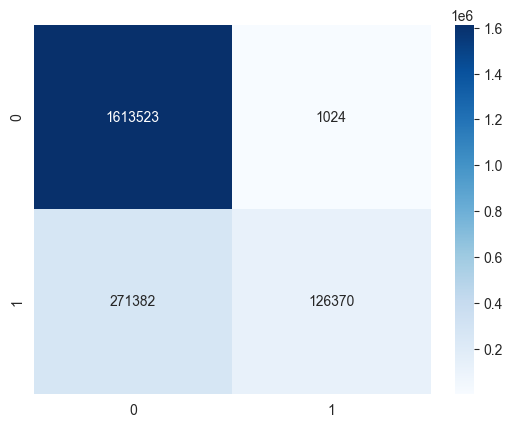

In [17]:
PortScan_vs_world_rf_cm = confusion_matrix(y_world_vs_PortScan_rf, y_pred_PortScan_vs_world_rf)
print(PortScan_vs_world_rf_cm)
sns.heatmap(PortScan_vs_world_rf_cm, annot=True, fmt='d', cmap='Blues')

In [54]:
PortScan_rf_features = pd.DataFrame(PortScan_rf_opt.feature_importances_, index=x_world_vs_PortScan_rf.columns)
PortScan_rf_features.to_csv('PortScan_rf_features.csv', index=True)

,0
Destination Port,0.002295
Flow Duration,0.028492
Total Fwd Packets,0.021367
Total Backward Packets,0.001286
Total Length of Fwd Packets,0.095521
...,...
Active Min,0.000032
Idle Mean,0.000136
Idle Std,0.000005
Idle Max,0.000164


In [19]:
world_vs_PortScan_rf['Predicted Label'] = y_pred_PortScan_vs_world_rf
ps_rf_midindex = len(world_vs_PortScan_rf)//2
world_vs_PortScan_rf_I = world_vs_PortScan_rf.iloc[:ps_rf_midindex]
world_vs_PortScan_rf_II = world_vs_PortScan_rf.iloc[ps_rf_midindex:]
world_vs_PortScan_rf_I.to_csv('RF_PortScan_Results_I.csv', index=False)
world_vs_PortScan_rf_II.to_csv('RF_PortScan_Results_II.csv', index=False)

## BruteForce with RandomForest

In [20]:
BruteForce_vs_World_rf = not_a_matter_of_size(df_BruteForce, 250000)
world_vs_BruteForce_rf = pd.concat([df_DOS, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_BruteForce_vs_world_rf, x_world_vs_BruteForce_rf, y_BruteForce_vs_world_rf, y_world_vs_BruteForce_rf = my_train_test_split(BruteForce_vs_World_rf, world_vs_BruteForce_rf)

C:\Users\Comar\AppData\Local\Temp\ipykernel_8700\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [21]:
BruteForce_rf_opt = RandomForestClassifier(criterion='gini', max_depth=None, max_features=None, n_estimators=100, n_jobs=6)
BruteForce_rf_opt.fit(x_BruteForce_vs_world_rf, y_BruteForce_vs_world_rf)
y_pred_BruteForce_vs_world_rf = BruteForce_rf_opt.predict(x_world_vs_BruteForce_rf)

In [22]:
rf_BruteForce_vs_world_cl = classification_report(y_world_vs_BruteForce_rf, y_pred_BruteForce_vs_world_rf)
print('Score =', BruteForce_rf_opt.score(x_world_vs_BruteForce_rf, y_world_vs_BruteForce_rf))
print('\nReport :\n', rf_BruteForce_vs_world_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_BruteForce_rf, y_pred_BruteForce_vs_world_rf))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_BruteForce_rf, y_pred_BruteForce_vs_world_rf))

Score = 0.7072918634462286

Report :
               precision    recall  f1-score   support

           0       0.71      1.00      0.83   1310026
           1       0.84      0.00      0.00    542724

    accuracy                           0.71   1852750
   macro avg       0.77      0.50      0.42   1852750
weighted avg       0.75      0.71      0.59   1852750

mean squared error (MSE) : 0.293
coefficient de détermination (r^2) : -0.413


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       It just takes to long to rerun the cell below.
       

[[1309930      96]
 [ 542219     505]]


<Axes: >

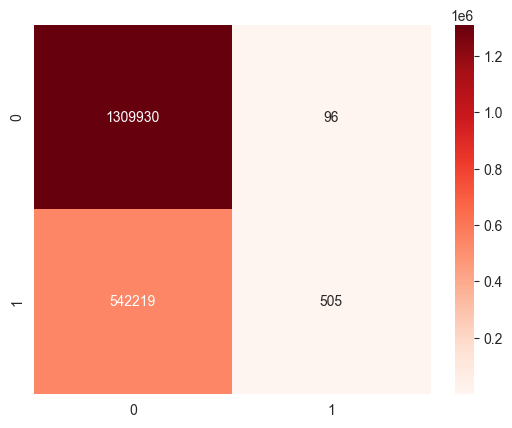

In [23]:
BruteForce_vs_world_rf_cm = confusion_matrix(y_world_vs_BruteForce_rf, y_pred_BruteForce_vs_world_rf)
print(BruteForce_vs_world_rf_cm)
sns.heatmap(BruteForce_vs_world_rf_cm, annot=True, fmt='d', cmap='Reds')

In [55]:
BruteForce_rf_features = pd.DataFrame(BruteForce_rf_opt.feature_importances_, index=x_world_vs_BruteForce_rf.columns)
BruteForce_rf_features.to_csv('BruteForce_rf_features.csv', index=True)

,0
Destination Port,0.047473
Flow Duration,0.001919
Total Fwd Packets,0.000054
Total Backward Packets,0.001101
Total Length of Fwd Packets,0.065721
...,...
Active Min,0.000417
Idle Mean,0.000170
Idle Std,0.000027
Idle Max,0.000198


In [25]:
world_vs_BruteForce_rf['Predicted Label'] = y_pred_BruteForce_vs_world_rf
bf_rf_midindex = len(world_vs_BruteForce_rf)//2
world_vs_BruteForce_rf_I = world_vs_BruteForce_rf.iloc[:bf_rf_midindex]
world_vs_BruteForce_rf_II = world_vs_BruteForce_rf.iloc[bf_rf_midindex:]
world_vs_BruteForce_rf_I.to_csv('RF_BruteForce_Results_I.csv', index=False)
world_vs_BruteForce_rf_II.to_csv('RF_BruteForce_Results_II.csv', index=False)

## Analysing the results of RandomForest Models

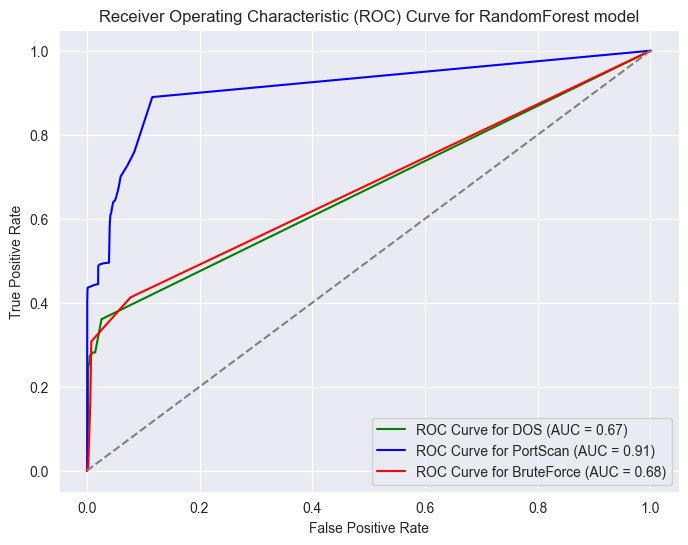

In [26]:
y_pp_DOS_rf = DOS_rf_opt.predict_proba(x_world_vs_DOS_rf)[:, 1]
fpr_DOS_rf, tpr_DOS_rf, th_DOS_rf = roc_curve(y_world_vs_DOS_rf, y_pp_DOS_rf)
auc_score_DOS_rf = roc_auc_score(y_world_vs_DOS_rf, y_pp_DOS_rf)

y_pp_PortScan_rf = PortScan_rf_opt.predict_proba(x_world_vs_PortScan_rf)[:, 1]
fpr_PortScan_rf, tpr_PortScan_rf, th_PortScan_rf = roc_curve(y_world_vs_PortScan_rf, y_pp_PortScan_rf)
auc_score_PortScan_rf = roc_auc_score(y_world_vs_PortScan_rf, y_pp_PortScan_rf)

y_pp_BruteForce_rf = BruteForce_rf_opt.predict_proba(x_world_vs_BruteForce_rf)[:, 1]
fpr_BruteForce_rf, tpr_BruteForce_rf, th_BruteForce_rf = roc_curve(y_world_vs_BruteForce_rf, y_pp_BruteForce_rf)
auc_score_BruteForce_rf = roc_auc_score(y_world_vs_BruteForce_rf, y_pp_BruteForce_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_DOS_rf, tpr_DOS_rf, color = 'green', label=f'ROC Curve for DOS (AUC = {auc_score_DOS_rf:.2f})')
plt.plot(fpr_PortScan_rf, tpr_PortScan_rf, color = 'blue', label=f'ROC Curve for PortScan (AUC = {auc_score_PortScan_rf:.2f})')
plt.plot(fpr_BruteForce_rf, tpr_BruteForce_rf, color = 'red', label=f'ROC Curve for BruteForce (AUC = {auc_score_BruteForce_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve for RandomForest model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### RandomForest trained with DOS dataset

Total number of false negative : (302664, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


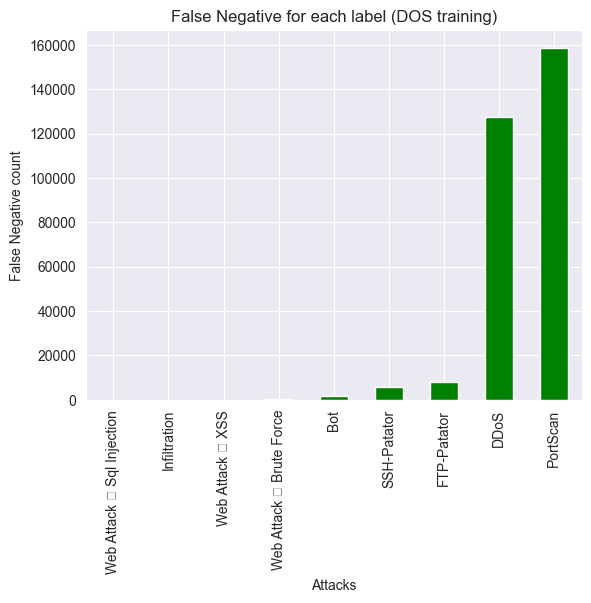

Label
PortScan                      158742
DDoS                          127741
FTP-Patator                     7934
SSH-Patator                     5889
Bot                             1956
Web Attack � Brute Force         299
Web Attack � XSS                  51
Infiltration                      36
Web Attack � Sql Injection        16
Name: count, dtype: int64

In [27]:
FN_DOS_RF = world_vs_DOS_rf[(world_vs_DOS_rf['Bin Label']==1) & (world_vs_DOS_rf['Predicted Label']==0)]
print('Total number of false negative :', FN_DOS_RF.shape)
fn_Label_count_rf = FN_DOS_RF.value_counts('Label')
fn_Label_count_rf.sort_values().plot(kind='bar', color='green')
plt.title('False Negative for each label (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count_rf.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


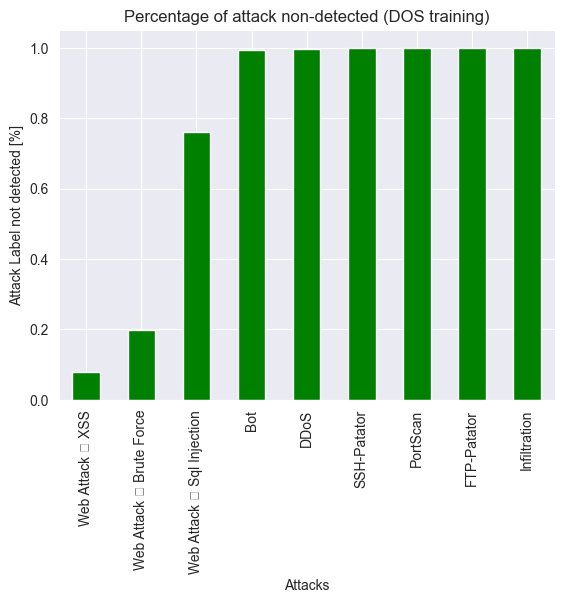

Infiltration                  1.000000
FTP-Patator                   0.999496
PortScan                      0.998817
SSH-Patator                   0.998643
DDoS                          0.997766
Bot                           0.994914
Web Attack � Sql Injection    0.761905
Web Attack � Brute Force      0.198407
Web Attack � XSS              0.078221
Name: count, dtype: float64

In [28]:
dos_rf_com_index = lab_count.index.intersection(fn_Label_count_rf.index)
dos_rf_res = (fn_Label_count_rf[dos_rf_com_index] / lab_count[dos_rf_com_index])
dos_rf_res.sort_values().plot(kind='bar', color='green')
plt.title('Percentage of attack non-detected (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
dos_rf_res.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


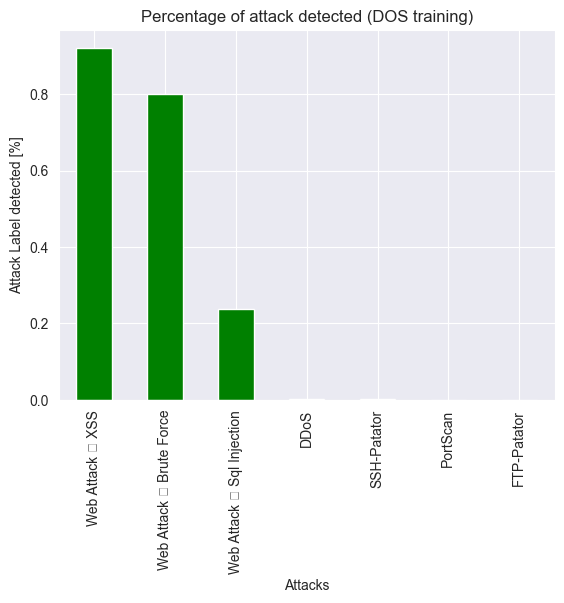

Web Attack � XSS              0.921779
Web Attack � Brute Force      0.801593
Web Attack � Sql Injection    0.238095
DDoS                          0.002218
SSH-Patator                   0.001357
PortScan                      0.000390
FTP-Patator                   0.000126
Name: count, dtype: float64

In [29]:
TP_DOS_RF = world_vs_DOS_rf[(world_vs_DOS_rf['Bin Label']==1) & (world_vs_DOS_rf['Predicted Label']==1)]
tp_Label_count_dos_rf = TP_DOS_RF.value_counts('Label')
dos_rf_tp_index = lab_count.index.intersection(tp_Label_count_dos_rf.index)
tp_dos_rf_res = (tp_Label_count_dos_rf[dos_rf_tp_index] / lab_count[dos_rf_tp_index])
tp_dos_rf_res.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Percentage of attack detected (DOS training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_dos_rf_res.sort_values(ascending=False)

In [15]:
features_path = r'Results/RandomForest/'
DOS_rf_features = pd.read_csv(Path(features_path+'DOS_rf_features.csv'))
DOS_rf_features.sort_values(ascending=False, by='0')

,Unnamed: 0,0
13,Bwd Packet Length Std,0.457595
40,Packet Length Mean,0.260251
67,Init_Win_bytes_backward,0.101584
0,Destination Port,0.043477
66,Init_Win_bytes_forward,0.023999
...,...,...
33,Bwd URG Flags,0.000000
32,Fwd URG Flags,0.000000
31,Bwd PSH Flags,0.000000
57,Fwd Avg Packets/Bulk,0.000000


To visualise the most important features, we select the classes which had the best and (one of) the worst detection percentage in the two last histograms. The entropy (or gini) level table is the basis for choosing the features to be analyzed. 


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


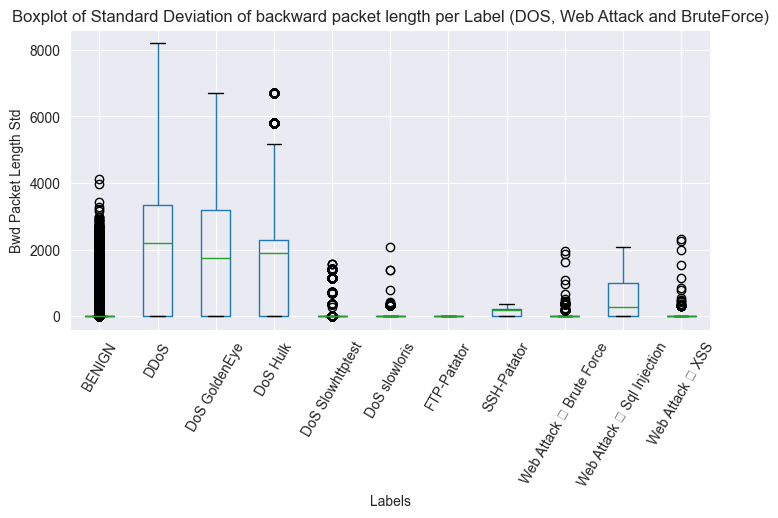

In [70]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] != 'Heartbleed')]
bwd_pck_dos = dos_bwd_pck[['Bwd Packet Length Std', 'Label']]
bwd_pck_web = df_WebAttack[['Bwd Packet Length Std', 'Label']]
bwd_pck_ddos = df_DDOS[['Bwd Packet Length Std', 'Label']]
bwd_pck_bf = df_BruteForce[['Bwd Packet Length Std', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_dos, bwd_pck_web, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Bwd Packet Length Std', by='Label', figsize=(8,4))
plt.title('Boxplot of Standard Deviation of backward packet length per Label (DOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Bwd Packet Length Std')
plt.xlabel('Labels')
plt.xticks(rotation=60)
plt.show()

The boxes of DOS attacks look very similar. Benign actions has a lot of outliers.


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


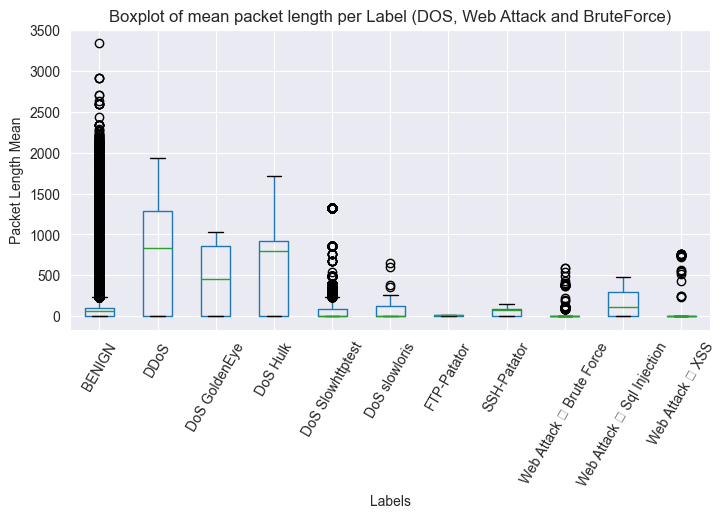

In [69]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] != 'Heartbleed')]
bwd_pck_dos = dos_bwd_pck[['Packet Length Mean', 'Label']]
bwd_pck_web = df_WebAttack[['Packet Length Mean', 'Label']]
bwd_pck_ddos = df_DDOS[['Packet Length Mean', 'Label']]
bwd_pck_bf = df_BruteForce[['Packet Length Mean', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_dos, bwd_pck_web, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Packet Length Mean', by='Label', figsize=(8,4))
plt.title('Boxplot of mean packet length per Label (DOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Packet Length Mean')
plt.xlabel('Labels')
plt.xticks(rotation=60)
plt.show()

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


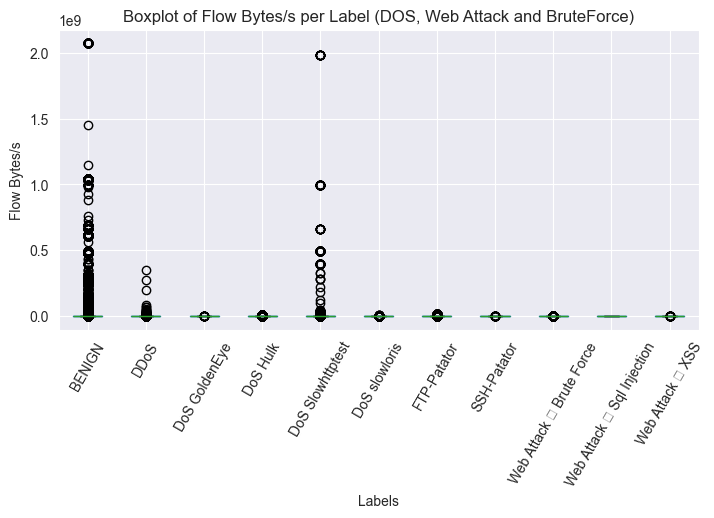

In [68]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] != 'Heartbleed')]
bwd_pck_dos = dos_bwd_pck[['Flow Bytes/s', 'Label']]
bwd_pck_web = df_WebAttack[['Flow Bytes/s', 'Label']]
bwd_pck_ddos = df_DDOS[['Flow Bytes/s', 'Label']]
bwd_pck_bf = df_BruteForce[['Flow Bytes/s', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_dos, bwd_pck_web, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Flow Bytes/s', by='Label', figsize=(8,4))
plt.title('Boxplot of Flow Bytes/s per Label (DOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Flow Bytes/s')
plt.xlabel('Labels')
plt.xticks(rotation=60)
plt.show()

### RandomForest trained with PortScan dataset

Total number of false negative : (271382, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


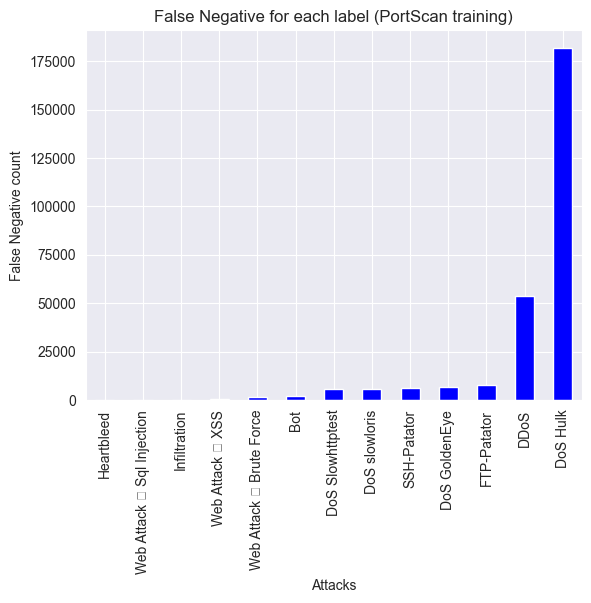

Label
DoS Hulk                      182043
DDoS                           53651
FTP-Patator                     7935
DoS GoldenEye                   6456
SSH-Patator                     5870
DoS slowloris                   5795
DoS Slowhttptest                5497
Bot                             1956
Web Attack � Brute Force        1472
Web Attack � XSS                 639
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [56]:
FN_PortScan_RF = world_vs_PortScan_rf[(world_vs_PortScan_rf['Bin Label']==1) & (world_vs_PortScan_rf['Predicted Label']==0)]
print('Total number of false negative :', FN_PortScan_RF.shape)
fn_Label_count_rf_ps = FN_PortScan_RF.value_counts('Label')
fn_Label_count_rf_ps.sort_values().plot(kind='bar', color='blue')
plt.title('False Negative for each label (PortScan training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count_rf_ps.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


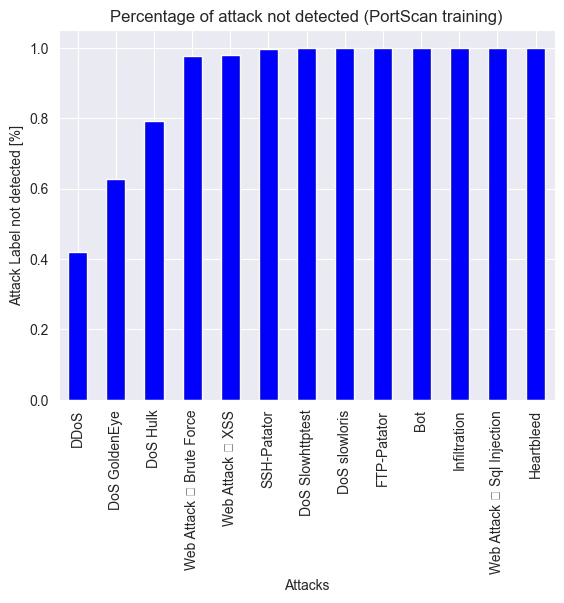

Label
FTP-Patator                   1.000000
Bot                           1.000000
Infiltration                  1.000000
Web Attack � Sql Injection    1.000000
Heartbleed                    1.000000
DoS slowloris                 0.999827
DoS Slowhttptest              0.999636
SSH-Patator                   0.995421
Web Attack � XSS              0.980061
Web Attack � Brute Force      0.976775
DoS Hulk                      0.791065
DoS GoldenEye                 0.627222
DDoS                          0.419067
Name: count, dtype: float64

In [57]:
ps_rf_com_index = lab_count.index.intersection(fn_Label_count_rf_ps.index)
ps_rf_res = (fn_Label_count_rf_ps[ps_rf_com_index] / lab_count[ps_rf_com_index])
ps_rf_res.sort_values().plot(kind='bar', color='blue')
plt.title('Percentage of attack not detected (PortScan training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
ps_rf_res.sort_values(ascending=False)

In [46]:
world_vs_PortScan_I = pd.read_csv('Results/RandomForest/RF_PortScan_Results_I.csv')
world_vs_PortScan_II = pd.read_csv('Results/RandomForest/RF_PortScan_Results_II.csv')
world_vs_PortScan_rf = pd.concat([world_vs_PortScan_I, world_vs_PortScan_II])

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


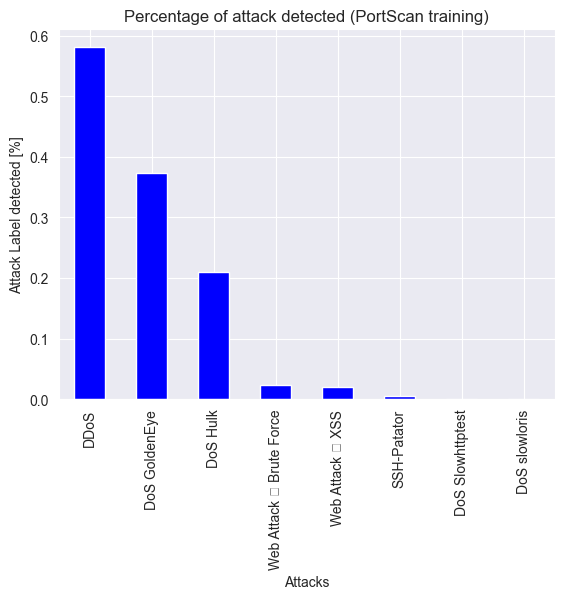

Label
DDoS                        0.580933
DoS GoldenEye               0.372778
DoS Hulk                    0.208935
Web Attack � Brute Force    0.023225
Web Attack � XSS            0.019939
SSH-Patator                 0.004579
DoS Slowhttptest            0.000364
DoS slowloris               0.000173
Name: count, dtype: float64

In [54]:
TP_PortScan_RF = world_vs_PortScan_rf[(world_vs_PortScan_rf['Bin Label']==1) & (world_vs_PortScan_rf['Predicted Label']==1)]
tp_Label_count_ps_rf = TP_PortScan_RF.value_counts('Label')
ps_rf_tp_index = lab_count.index.intersection(tp_Label_count_ps_rf.index)
tp_ps_rf_res = (tp_Label_count_ps_rf[ps_rf_tp_index] / lab_count[ps_rf_tp_index])
tp_ps_rf_res.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Percentage of attack detected (PortScan training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_ps_rf_res.sort_values(ascending=False)

In [22]:
PortScan_rf_features = pd.read_csv(Path(features_path+'PortScan_rf_features.csv'))
PortScan_rf_features.sort_values(ascending=False, by='0')

,Unnamed: 0,0
67,Init_Win_bytes_backward,0.120660
63,Subflow Fwd Bytes,0.100460
4,Total Length of Fwd Packets,0.095521
53,Avg Fwd Segment Size,0.083259
6,Fwd Packet Length Max,0.067703
...,...,...
50,ECE Flag Count,0.000000
56,Fwd Avg Bytes/Bulk,0.000000
61,Bwd Avg Bulk Rate,0.000000
60,Bwd Avg Packets/Bulk,0.000000


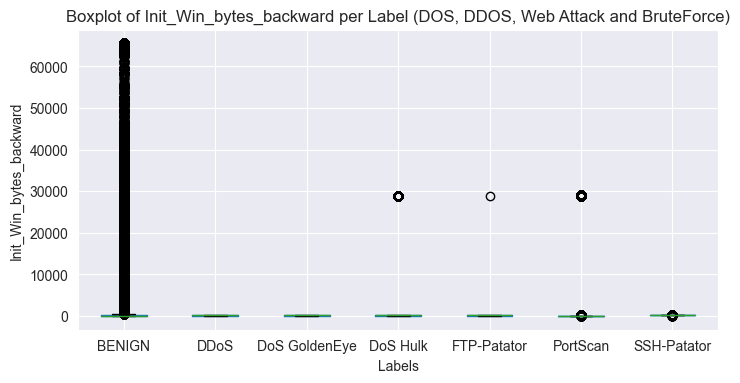

In [38]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] == 'DoS Hulk') | (df_DOS['Label'] == 'DoS GoldenEye')]
bwd_pck_dos = dos_bwd_pck[['Init_Win_bytes_backward', 'Label']]
bwd_pck_ddos = df_DDOS[['Init_Win_bytes_backward', 'Label']]
bwd_pck_bf = df_BruteForce[['Init_Win_bytes_backward', 'Label']]
bwd_pck_ps = df_PortScan[['Init_Win_bytes_backward', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_ps, bwd_pck_dos, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Init_Win_bytes_backward', by='Label', figsize=(8, 4))
plt.title('Boxplot of Init_Win_bytes_backward per Label (DOS, DDOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Init_Win_bytes_backward')
plt.xlabel('Labels')
plt.show()

Only Benign actions look different from the others.


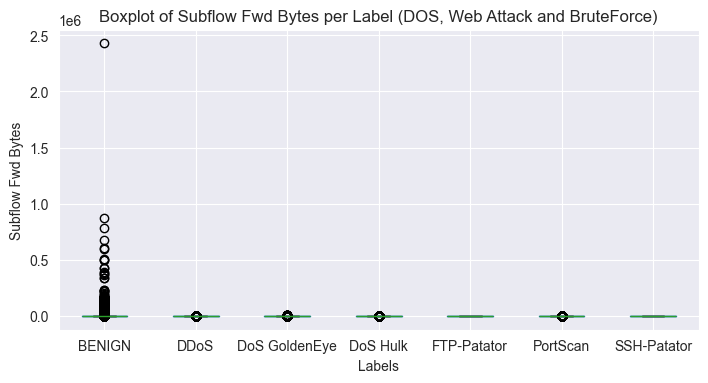

In [37]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] == 'DoS Hulk') | (df_DOS['Label'] == 'DoS GoldenEye')]
bwd_pck_dos = dos_bwd_pck[['Subflow Fwd Bytes', 'Label']]
bwd_pck_ddos = df_DDOS[['Subflow Fwd Bytes', 'Label']]
bwd_pck_bf = df_BruteForce[['Subflow Fwd Bytes', 'Label']]
bwd_pck_ps = df_PortScan[['Subflow Fwd Bytes', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_ps, bwd_pck_dos, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Subflow Fwd Bytes', by='Label', figsize=(8, 4))
plt.title('Boxplot of Subflow Fwd Bytes per Label (DDOS, DOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Subflow Fwd Bytes')
plt.xlabel('Labels')
plt.show()

Once again, only Benign actions look different from the others.


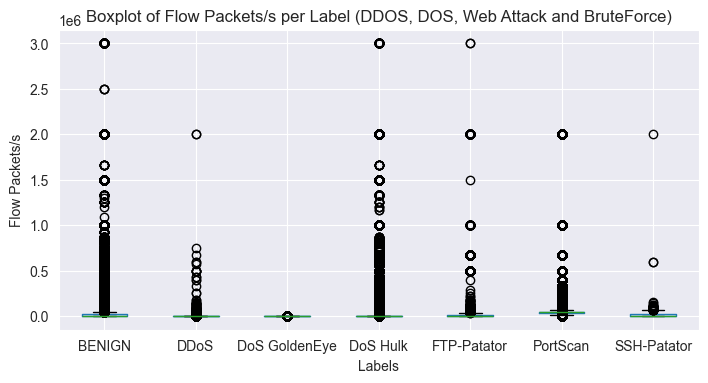

In [41]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] == 'DoS Hulk') | (df_DOS['Label'] == 'DoS GoldenEye')]
bwd_pck_dos = dos_bwd_pck[['Flow Packets/s', 'Label']]
bwd_pck_ddos = df_DDOS[['Flow Packets/s', 'Label']]
bwd_pck_bf = df_BruteForce[['Flow Packets/s', 'Label']]
bwd_pck_ps = df_PortScan[['Flow Packets/s', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_ps, bwd_pck_dos, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Flow Packets/s', by='Label', figsize=(8, 4))
plt.title('Boxplot of Flow Packets/s per Label (DDOS, DOS, Web Attack and BruteForce)')
plt.suptitle('')
plt.ylabel('Flow Packets/s')
plt.xlabel('Labels')
plt.show()

### RandomForest Trained with BruteForce dataset

Total number of false negative : (542219, 81)


C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


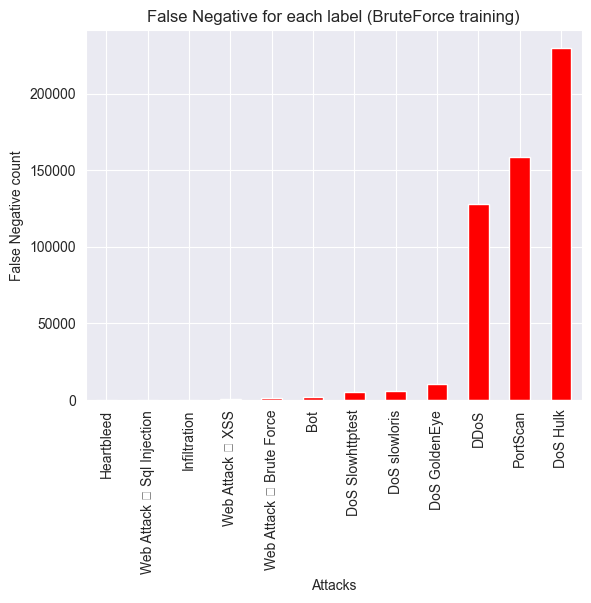

Label
DoS Hulk                      229874
PortScan                      158802
DDoS                          128025
DoS GoldenEye                  10293
DoS slowloris                   5788
DoS Slowhttptest                5341
Bot                             1956
Web Attack � Brute Force        1428
Web Attack � XSS                 646
Infiltration                      36
Web Attack � Sql Injection        19
Heartbleed                        11
Name: count, dtype: int64

In [35]:
FN_BruteForce_RF = world_vs_BruteForce_rf[(world_vs_BruteForce_rf['Bin Label']==1) & (world_vs_BruteForce_rf['Predicted Label']==0)]
print('Total number of false negative :', FN_BruteForce_RF.shape)
fn_Label_count_rf_bf = FN_BruteForce_RF.value_counts('Label')
fn_Label_count_rf_bf.sort_values().plot(kind='bar', color='red')
plt.title('False Negative for each label (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('False Negative count')
plt.show()
fn_Label_count_rf_bf.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


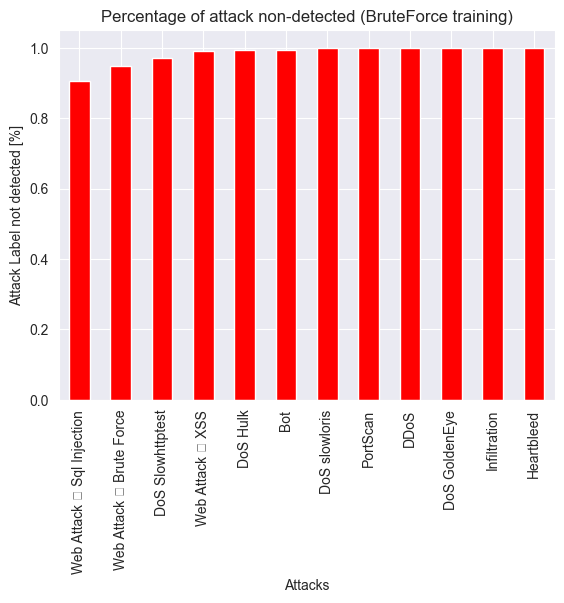

DoS GoldenEye                 1.000000
Infiltration                  1.000000
Heartbleed                    1.000000
DDoS                          0.999984
PortScan                      0.999195
DoS slowloris                 0.998620
Bot                           0.994914
DoS Hulk                      0.994811
Web Attack � XSS              0.990798
DoS Slowhttptest              0.971268
Web Attack � Brute Force      0.947578
Web Attack � Sql Injection    0.904762
Name: count, dtype: float64

In [36]:
bf_rf_com_index = lab_count.index.intersection(fn_Label_count_rf_bf.index)
bf_rf_res = (fn_Label_count_rf_bf[bf_rf_com_index] / lab_count[bf_rf_com_index])
bf_rf_res.sort_values().plot(kind='bar', color='red')
plt.title('Percentage of attack non-detected (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label not detected [%]')
plt.show()
bf_rf_res.sort_values(ascending=False)

C:\Users\Comar\Desktop\Marco_Unil\Master_I\Machine_Learning\TP\Projet\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


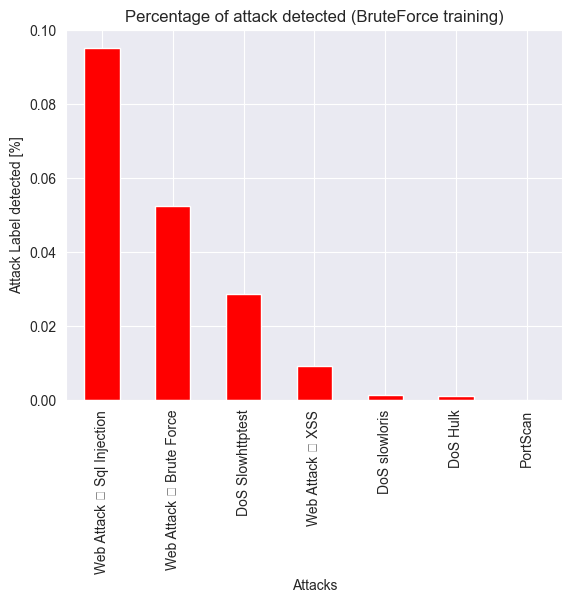

Web Attack � Sql Injection    0.095238
Web Attack � Brute Force      0.052422
DoS Slowhttptest              0.028732
Web Attack � XSS              0.009202
DoS slowloris                 0.001380
DoS Hulk                      0.001082
PortScan                      0.000013
Name: count, dtype: float64

In [37]:
TP_BruteForce_RF = world_vs_BruteForce_rf[(world_vs_BruteForce_rf['Bin Label']==1) & (world_vs_BruteForce_rf['Predicted Label']==1)]
tp_Label_count_bf_rf = TP_BruteForce_RF.value_counts('Label')
bf_rf_tp_index = lab_count.index.intersection(tp_Label_count_bf_rf.index)
tp_bf_rf_res = (tp_Label_count_bf_rf[bf_rf_tp_index] / lab_count[bf_rf_tp_index])
tp_bf_rf_res.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Percentage of attack detected (BruteForce training)')
plt.xlabel('Attacks')
plt.ylabel('Attack Label detected [%]')
plt.show()
tp_bf_rf_res.sort_values(ascending=False)

In [9]:
features_path = r'Results/RandomForest/'
BruteForce_rf_features = pd.read_csv(Path(features_path+'BruteForce_rf_features.csv'))
BruteForce_rf_features.sort_values(ascending=False, by='0')

,Unnamed: 0,0
42,Packet Length Variance,0.168254
41,Packet Length Std,0.127669
37,Bwd Packets/s,0.104116
6,Fwd Packet Length Max,0.084191
35,Bwd Header Length,0.077161
...,...,...
46,PSH Flag Count,0.000000
45,RST Flag Count,0.000000
43,FIN Flag Count,0.000000
7,Fwd Packet Length Min,0.000000


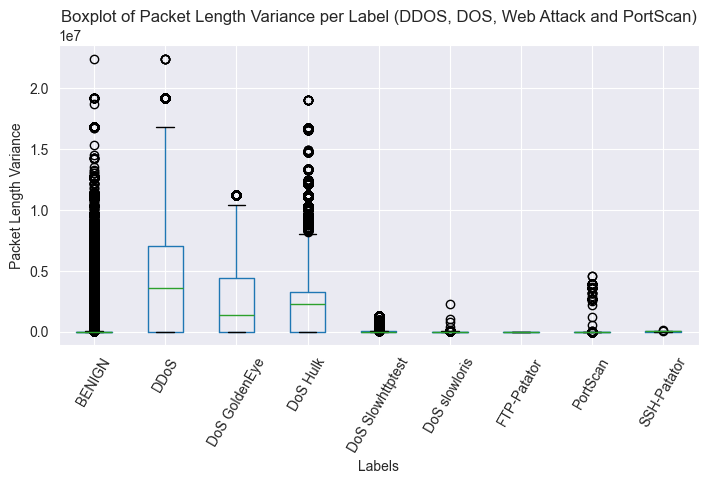

In [67]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] != 'Heartbleed')]
bwd_pck_dos = dos_bwd_pck[['Packet Length Variance', 'Label']]
bwd_pck_ddos = df_DDOS[['Packet Length Variance', 'Label']]
bwd_pck_bf = df_BruteForce[['Packet Length Variance', 'Label']]
bwd_pck_ps = df_PortScan[['Packet Length Variance', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_ps, bwd_pck_dos, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Packet Length Variance', by='Label', figsize=(8, 4))
plt.title('Boxplot of Packet Length Variance per Label (DDOS, DOS, Web Attack and PortScan)')
plt.suptitle('')
plt.ylabel('Packet Length Variance')
plt.xlabel('Labels')
plt.xticks(rotation=60)
plt.show()

On these boxplots, the difference between training classes (BruteForce-Patator) and other attacks is that BruteForce attacks have no boxes or outliers, unlike the others.


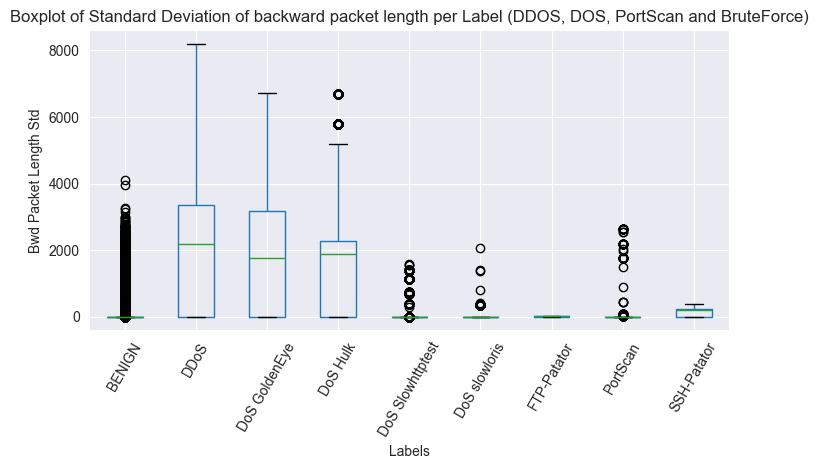

In [66]:
dos_bwd_pck = df_DOS[(df_DOS['Label'] != 'Heartbleed')]
bwd_pck_dos = dos_bwd_pck[['Bwd Packet Length Std', 'Label']]
bwd_pck_ddos = df_DDOS[['Bwd Packet Length Std', 'Label']]
bwd_pck_bf = df_BruteForce[['Bwd Packet Length Std', 'Label']]
bwd_pck_ps = df_PortScan[['Bwd Packet Length Std', 'Label']]
bwd_pck_fin = pd.concat([bwd_pck_ps, bwd_pck_dos, bwd_pck_ddos, bwd_pck_bf])
bwd_pck_fin.boxplot(column='Bwd Packet Length Std', by='Label', figsize=(8,4))
plt.title('Boxplot of Standard Deviation of backward packet length per Label (DDOS, DOS, PortScan and BruteForce)')
plt.suptitle('')
plt.ylabel('Bwd Packet Length Std')
plt.xlabel('Labels')
plt.xticks(rotation=60)
plt.show()

# Naive Bayes Classifier

## DOS with Naive Bayes
### big training set 

In [32]:
DOS_vs_World_nb = not_a_matter_of_size(df_DOS, 220000)
world_vs_DOS_nb = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_DOS_vs_world_nb, x_world_vs_DOS_nb, y_DOS_vs_world_nb, y_world_vs_DOS_nb = my_train_test_split(DOS_vs_World_nb, world_vs_DOS_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [33]:
DOS_nb_opt = ComplementNB(alpha=0.0001, norm=True)
DOS_nb_opt.fit(x_DOS_vs_world_nb, y_DOS_vs_world_nb)
y_pred_DOS_vs_world_nb = DOS_nb_opt.predict(x_world_vs_DOS_nb)

In [34]:
DOS_vs_world_nb_cl = classification_report(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb)
print('Score =', DOS_nb_opt.score(x_world_vs_DOS_nb, y_world_vs_DOS_nb))
print('\nReport :\n', DOS_vs_world_nb_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb))

Score = 0.46066338973073245

Report :
               precision    recall  f1-score   support

           0       0.78      0.47      0.58   1302156
           1       0.16      0.43      0.23    304833

    accuracy                           0.46   1606989
   macro avg       0.47      0.45      0.41   1606989
weighted avg       0.66      0.46      0.52   1606989

mean squared error (MSE) : 0.539
coefficient de détermination (r^2) : -2.509


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.
       

[[608534 693622]
 [173086 131747]]


<Axes: >

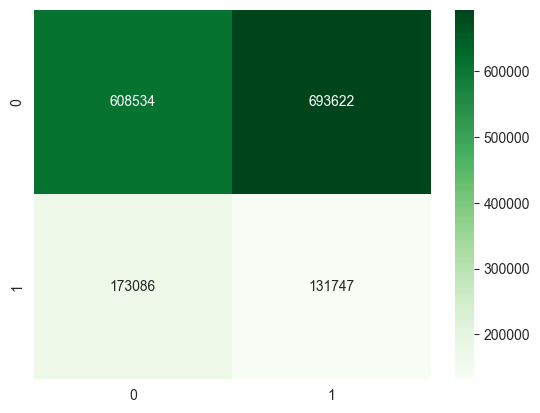

In [35]:
DOS_vs_world_nb_cm = confusion_matrix(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb)
print(DOS_vs_world_nb_cm)
sns.heatmap(DOS_vs_world_nb_cm, annot=True, fmt='d', cmap='Greens')

### DOS Small training set

In [36]:
DOS_vs_World_nb_small = not_a_matter_of_size(df_DOS, 10000)
world_vs_DOS_nb = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_PortScan], axis=0, ignore_index=True)
x_DOS_vs_world_nb_small, x_world_vs_DOS_nb, y_DOS_vs_world_nb_small, y_world_vs_DOS_nb = my_train_test_split(DOS_vs_World_nb_small, world_vs_DOS_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [37]:
DOS_nb_opt_small = ComplementNB(alpha=0.0001, norm=True)
DOS_nb_opt_small.fit(x_DOS_vs_world_nb_small, y_DOS_vs_world_nb_small)
y_pred_DOS_vs_world_nb_small = DOS_nb_opt_small.predict(x_world_vs_DOS_nb)

In [38]:
DOS_vs_world_nb_cl_small = classification_report(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb_small)
print('Score =', DOS_nb_opt_small.score(x_world_vs_DOS_nb, y_world_vs_DOS_nb))
print('\nReport :\n', DOS_vs_world_nb_cl_small)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb_small))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb_small))

Score = 0.4718694403010848

Report :
               precision    recall  f1-score   support

           0       0.78      0.48      0.60   1302156
           1       0.16      0.43      0.24    304833

    accuracy                           0.47   1606989
   macro avg       0.47      0.46      0.42   1606989
weighted avg       0.67      0.47      0.53   1606989

mean squared error (MSE) : 0.528
coefficient de détermination (r^2) : -2.436


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.


[[627243 674913]
 [173787 131046]]


<Axes: >

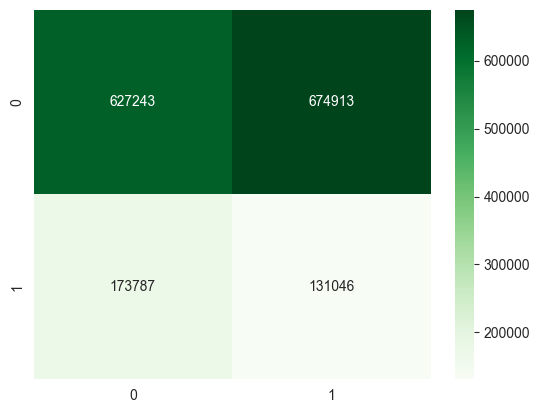

In [39]:
DOS_vs_world_nb_cm_small = confusion_matrix(y_world_vs_DOS_nb, y_pred_DOS_vs_world_nb_small)
print(DOS_vs_world_nb_cm_small)
sns.heatmap(DOS_vs_world_nb_cm_small, annot=True, fmt='d', cmap='Greens')

## PortScan with Naive Bayes 

In [40]:
PortScan_vs_World_nb = not_a_matter_of_size(df_PortScan, 180000)
world_vs_PortScan_nb = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_PortScan_vs_world_nb, x_world_vs_PortScan_nb, y_PortScan_vs_world_nb, y_world_vs_PortScan_nb = my_train_test_split(PortScan_vs_World_nb, world_vs_PortScan_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [41]:
PortScan_nb_opt = ComplementNB(alpha=1, norm=True)
PortScan_nb_opt.fit(x_PortScan_vs_world_nb, y_PortScan_vs_world_nb)
y_pred_PortScan_vs_world_nb = PortScan_nb_opt.predict(x_world_vs_PortScan_nb)

In [42]:
PortScan_vs_world_nb_cl = classification_report(y_world_vs_PortScan_nb, y_pred_PortScan_vs_world_nb)
print('Score =', PortScan_nb_opt.score(x_world_vs_PortScan_nb, y_world_vs_PortScan_nb))
print('\nReport :\n', PortScan_vs_world_nb_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_PortScan_nb, y_pred_PortScan_vs_world_nb))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_PortScan_nb, y_pred_PortScan_vs_world_nb))

Score = 0.48255055535981484

Report :
               precision    recall  f1-score   support

           0       0.74      0.55      0.63   1614547
           1       0.11      0.22      0.15    397752

    accuracy                           0.48   2012299
   macro avg       0.42      0.38      0.39   2012299
weighted avg       0.62      0.48      0.53   2012299

mean squared error (MSE) : 0.517
coefficient de détermination (r^2) : -2.263


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.


[[882713 731834]
 [309429  88323]]


<Axes: >

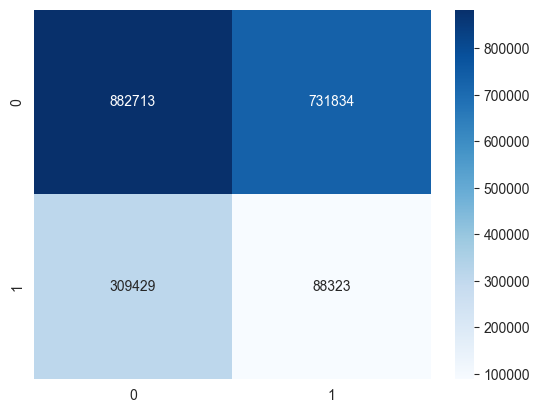

In [43]:
PortScan_vs_world_nb_cm = confusion_matrix(y_world_vs_PortScan_nb, y_pred_PortScan_vs_world_nb)
print(PortScan_vs_world_nb_cm)
sns.heatmap(PortScan_vs_world_nb_cm, annot=True, fmt='d', cmap='Blues')

### PortScan small dataset

In [44]:
PS_vs_World_nb_small = not_a_matter_of_size(df_PortScan, 10000)
world_vs_PS_nb = pd.concat([df_BruteForce, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_PS_vs_world_nb_small, x_world_vs_PS_nb, y_PS_vs_world_nb_small, y_world_vs_PS_nb = my_train_test_split(PS_vs_World_nb_small, world_vs_PS_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [45]:
PS_nb_opt_small = ComplementNB(alpha=1, norm=False)
PS_nb_opt_small.fit(x_PS_vs_world_nb_small, y_PS_vs_world_nb_small)
y_pred_PS_vs_world_nb_small = PS_nb_opt_small.predict(x_world_vs_PS_nb)

In [46]:
PS_vs_world_nb_cl_small = classification_report(y_world_vs_PS_nb, y_pred_PS_vs_world_nb_small)
print('Score =', PS_nb_opt_small.score(x_world_vs_PS_nb, y_world_vs_PS_nb))
print('\nReport :\n', PS_vs_world_nb_cl_small)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_PS_nb, y_pred_PS_vs_world_nb_small))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_PS_nb, y_pred_PS_vs_world_nb_small))

Score = 0.48299581722199336

Report :
               precision    recall  f1-score   support

           0       0.76      0.52      0.62   1614547
           1       0.15      0.33      0.20    397752

    accuracy                           0.48   2012299
   macro avg       0.45      0.43      0.41   2012299
weighted avg       0.64      0.48      0.54   2012299

mean squared error (MSE) : 0.517
coefficient de détermination (r^2) : -2.260


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.


[[839107 775440]
 [264927 132825]]


<Axes: >

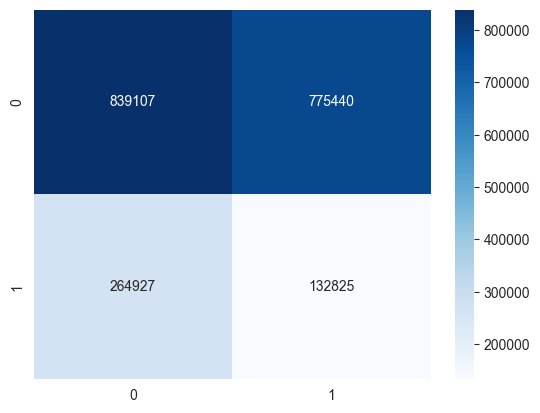

In [47]:
PS_vs_world_nb_cm_small = confusion_matrix(y_world_vs_PS_nb, y_pred_PS_vs_world_nb_small)
print(PS_vs_world_nb_cm_small)
sns.heatmap(PS_vs_world_nb_cm_small, annot=True, fmt='d', cmap='Blues')

## BruteForce with Naive Bayes

In [48]:
BF_vs_World_nb = not_a_matter_of_size(df_BruteForce, 275000)
world_vs_BF_nb = pd.concat([df_PortScan, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_BF_vs_world_nb, x_world_vs_BF_nb, y_BF_vs_world_nb, y_world_vs_BF_nb = my_train_test_split(BF_vs_World_nb, world_vs_BF_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [49]:
BF_nb_opt = ComplementNB(alpha=0.0001, norm=False)
BF_nb_opt.fit(x_BF_vs_world_nb, y_BF_vs_world_nb)
y_pred_BF_vs_world_nb = BF_nb_opt.predict(x_world_vs_BF_nb)

In [50]:
BF_vs_world_nb_cl = classification_report(y_world_vs_BF_nb, y_pred_BF_vs_world_nb)
print('Score =', BF_nb_opt.score(x_world_vs_BF_nb, y_world_vs_BF_nb))
print('\nReport :\n', BF_vs_world_nb_cl)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_BF_nb, y_pred_BF_vs_world_nb))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_BF_nb, y_pred_BF_vs_world_nb))

Score = 0.5258631763594657

Report :
               precision    recall  f1-score   support

           0       0.71      0.56      0.62   1310026
           1       0.30      0.45      0.36    542724

    accuracy                           0.53   1852750
   macro avg       0.50      0.50      0.49   1852750
weighted avg       0.59      0.53      0.55   1852750

mean squared error (MSE) : 0.474
coefficient de détermination (r^2) : -1.289


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.


[[732003 578023]
 [300434 242290]]


<Axes: >

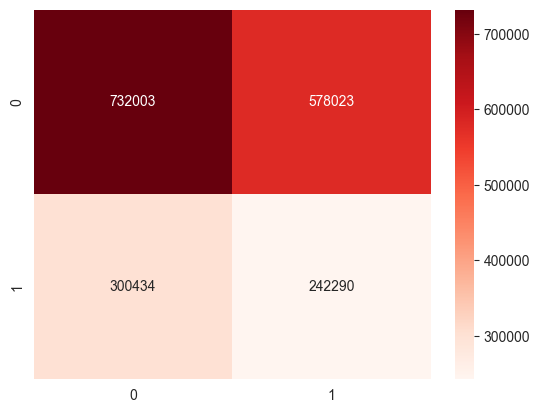

In [51]:
BF_vs_world_nb_cm = confusion_matrix(y_world_vs_BF_nb, y_pred_BF_vs_world_nb)
print(BF_vs_world_nb_cm)
sns.heatmap(BF_vs_world_nb_cm, annot=True, fmt='d', cmap='Reds')

### BruteForce small dataset

In [52]:
BF_vs_World_nb_small = not_a_matter_of_size(df_PortScan, 10000)
world_vs_BF_nb = pd.concat([df_PortScan, df_WebAttack, df_infiltration, df_bot, df_DDOS, df_DOS], axis=0, ignore_index=True)
x_BF_vs_world_nb_small, x_world_vs_BF_nb, y_BF_vs_world_nb_small, y_world_vs_BF_nb = my_train_test_split(BF_vs_World_nb_small, world_vs_BF_nb)

C:\Users\Comar\AppData\Local\Temp\ipykernel_22820\848046497.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shorted_df = subdf.groupby('Label', group_keys=False).apply(lambda x: x.sample(frac=good_percent))


In [53]:
BF_nb_opt_small = ComplementNB(alpha=0.00001, norm=False)
BF_nb_opt_small.fit(x_BF_vs_world_nb_small, y_BF_vs_world_nb_small)
y_pred_BF_vs_world_nb_small = BF_nb_opt_small.predict(x_world_vs_BF_nb)

In [54]:
BF_vs_world_nb_cl_small = classification_report(y_world_vs_BF_nb, y_pred_BF_vs_world_nb_small)
print('Score =', BF_nb_opt_small.score(x_world_vs_BF_nb, y_world_vs_BF_nb))
print('\nReport :\n', BF_vs_world_nb_cl_small)
print('mean squared error (MSE) : %.3f' % mean_squared_error(y_world_vs_BF_nb, y_pred_BF_vs_world_nb_small))
print('coefficient de détermination (r^2) : %.3f' % r2_score(y_world_vs_BF_nb, y_pred_BF_vs_world_nb_small))

Score = 0.5368678990689516

Report :
               precision    recall  f1-score   support

           0       0.73      0.55      0.63   1310026
           1       0.32      0.50      0.39    542724

    accuracy                           0.54   1852750
   macro avg       0.52      0.52      0.51   1852750
weighted avg       0.61      0.54      0.56   1852750

mean squared error (MSE) : 0.463
coefficient de détermination (r^2) : -1.236


Note : Don't look at the MSE and r^2 score. Those are usefull for regression, not classification.


[[725607 584419]
 [273649 269075]]


<Axes: >

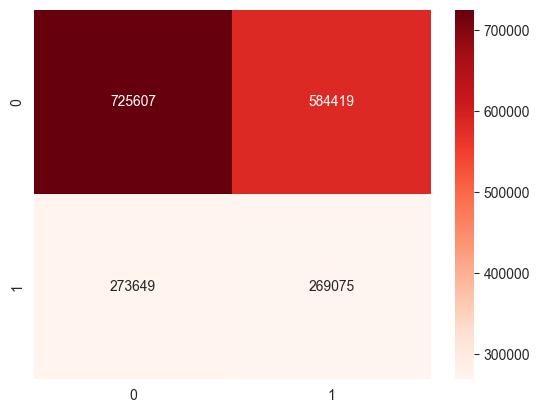

In [55]:
BF_vs_world_nb_cm_small = confusion_matrix(y_world_vs_BF_nb, y_pred_BF_vs_world_nb_small)
print(BF_vs_world_nb_cm_small)
sns.heatmap(BF_vs_world_nb_cm_small, annot=True, fmt='d', cmap='Reds')

## Analysing the Results of Naive Bayes model 

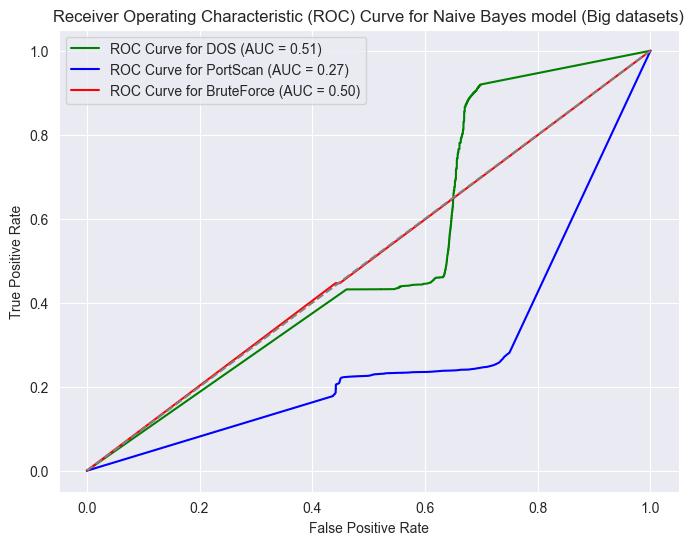

In [56]:
y_pp_DOS_nb = DOS_nb_opt.predict_proba(x_world_vs_DOS_nb)[:, 1]
fpr_DOS_nb, tpr_DOS_nb, th_DOS_nb = roc_curve(y_world_vs_DOS_nb, y_pp_DOS_nb)
auc_score_DOS_nb = roc_auc_score(y_world_vs_DOS_nb, y_pp_DOS_nb)

y_pp_PortScan_nb = PortScan_nb_opt.predict_proba(x_world_vs_PortScan_nb)[:, 1]
fpr_PortScan_nb, tpr_PortScan_nb, th_PortScan_nb = roc_curve(y_world_vs_PortScan_nb, y_pp_PortScan_nb)
auc_score_PortScan_nb = roc_auc_score(y_world_vs_PortScan_nb, y_pp_PortScan_nb)

y_pp_BruteForce_nb = BF_nb_opt.predict_proba(x_world_vs_BF_nb)[:, 1]
fpr_BruteForce_nb, tpr_BruteForce_nb, th_BruteForce_nb = roc_curve(y_world_vs_BF_nb, y_pp_BruteForce_nb)
auc_score_BruteForce_nb = roc_auc_score(y_world_vs_BF_nb, y_pp_BruteForce_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_DOS_nb, tpr_DOS_nb, color = 'green', label=f'ROC Curve for DOS (AUC = {auc_score_DOS_nb:.2f})')
plt.plot(fpr_PortScan_nb, tpr_PortScan_nb, color = 'blue', label=f'ROC Curve for PortScan (AUC = {auc_score_PortScan_nb:.2f})')
plt.plot(fpr_BruteForce_nb, tpr_BruteForce_nb, color = 'red', label=f'ROC Curve for BruteForce (AUC = {auc_score_BruteForce_nb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes model (Big datasets)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

ROC-AUC Curves with the small datasets :

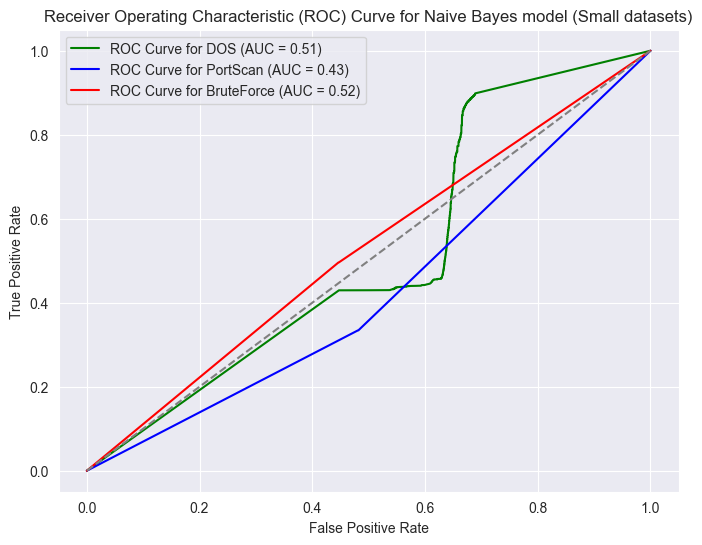

In [57]:
y_pp_DOS_nb_small = DOS_nb_opt_small.predict_proba(x_world_vs_DOS_nb)[:, 1]
fpr_DOS_nb_small, tpr_DOS_nb_small, th_DOS_nb_small = roc_curve(y_world_vs_DOS_nb, y_pp_DOS_nb_small)
auc_score_DOS_nb_small = roc_auc_score(y_world_vs_DOS_nb, y_pp_DOS_nb_small)

y_pp_PortScan_nb_small = PS_nb_opt_small.predict_proba(x_world_vs_PortScan_nb)[:, 1]
fpr_PortScan_nb_small, tpr_PortScan_nb_small, th_PortScan_nb_small = roc_curve(y_world_vs_PortScan_nb, y_pp_PortScan_nb_small)
auc_score_PortScan_nb_small = roc_auc_score(y_world_vs_PortScan_nb, y_pp_PortScan_nb_small)

y_pp_BruteForce_nb_small = BF_nb_opt_small.predict_proba(x_world_vs_BF_nb)[:, 1]
fpr_BruteForce_nb_small, tpr_BruteForce_nb_small, th_BruteForce_nb_small = roc_curve(y_world_vs_BF_nb, y_pp_BruteForce_nb_small)
auc_score_BruteForce_nb_small = roc_auc_score(y_world_vs_BF_nb, y_pp_BruteForce_nb_small)

plt.figure(figsize=(8, 6))
plt.plot(fpr_DOS_nb_small, tpr_DOS_nb_small, color = 'green', label=f'ROC Curve for DOS (AUC = {auc_score_DOS_nb_small:.2f})')
plt.plot(fpr_PortScan_nb_small, tpr_PortScan_nb_small, color = 'blue', label=f'ROC Curve for PortScan (AUC = {auc_score_PortScan_nb_small:.2f})')
plt.plot(fpr_BruteForce_nb_small, tpr_BruteForce_nb_small, color = 'red', label=f'ROC Curve for BruteForce (AUC = {auc_score_BruteForce_nb_small:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes model (Small datasets)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Classifier Comparison

When we look at the ROC-AUC curves for each classifier, the KNN and RandomForest models have the best scores. 
- KNN achieves an AUC of 0.85 with the DOS dataset.
- RandomForest achieves an AUC of 0.91 with the PortScan dataset.

RandomForest has a very low FP rate (very good for detecting benign actions), much lower than KNN. However, its FN rate is higher than KNN's.

For RF and KNN, the AUC scores seem 'good' because, in both cases, the TN rate was rather good (KNN) or even very good (RF). This has the effect of increasing the AUC score, as the 'Benign' class is over-represented.

Naïve Bayes Classifiers and BruteForce dataset had the worst scores in every case.


# Model Attacks

To counter the detection model, attackers simply need to perform an attack on the network that has never been seen before, such as a zero-day breach. As the system has never seen this type of attack in its training set, it should not be able to detect new attacks.

Another possibility would be to first identify which type of attack is present in the model's training dataset. This can be done by performing a variety of repeated intrusion tests to determine which attacks are detected and which are not. The result is a list of detected attacks that are normally present in the dataset. All you must do then is carry out attacks that are totally different from those in the training set.

For example, if the model has only been trained with DOS-type actions, the ideal would be to attack the network with BruteForce-type attacks. But not with DDOS-type attacks, which may still be detected.

In all these cases, knowledge of the classification algorithm used for the model is of lesser importance. For the three models presented above, some attacks were not detected at all, depending on the training dataset. The aim of the attackers is not to steal the model, but to override it.


# Discussion and conclusion

The RandomForest model is very good at recognizing true negatives. KNN was a little better for true positives. However, in both cases, the false-negative rate was too high, regardless of the sub-dataset used for training.

The Baysian model needs much less training data to work. In fact, the results were practically better with a training size of 10,000 lines rather than 150'000 or 180'000 lines. In any case, Baysian models don't seem at all suited to this kind of problem with unbalanced data.

The advantage of the models presented in this work is that the dataset used represents real-life network traffic very well, with many legitimate actions and very few malicious ones. This allows us to see what this kind of model would produce in a real-life scenario.

The disadvantage is that, precisely, 'Benign' actions are so over-represented that it becomes difficult to identify characteristics that are correlated between attacks of different kinds. The 'scatterplots' and 'boxplots' in the analysis of RandomForest and KNN results clearly demonstrate this. Some attacks form distinctive clusters on the graphs, even though they remain undetected. 

To really visualize the correlations between the different characteristics of the different attacks, we'd have to run the same tests, but considerably reduce the number of 'Benign' actions. Or even delete them all and keep only the attacks.
